In [131]:
import sys
print(sys.version)

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [772]:
import datetime
import sqlite3
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

from scipy.stats import variation

#set max columns displayed to 100
pd.set_option('display.max_columns',100)

### TRAIN DATASET

In [3]:
# First, let's import the train dataset: daily historical data from January 2013 to October 2015.
sales = pd.read_csv('./Data/competitive-data-science-predict-future-sales/sales_train.csv')

In [4]:
sales.shape

(2935849, 6)

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Per Kaggle documentation, the columns in this dataset are:

- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

In [8]:
# Let's convert the date column from string to datetime type
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

In [194]:
sales.date.describe()

count                 2935843
unique                   1034
top       2013-12-28 00:00:00
freq                     9434
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object

In [264]:
#check that there is datetime value for each day between the first and last day in the dataset
(sales.date.max() - sales.date.min()).days + 1

1034

**FINDING:** The number of days between the first and last dates in the dataset matches the number of unique dates in the dataset, so there are no gaps in dates.

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [10]:
# Determine if there are any null values in the dataset
sales.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [11]:
# Determine if there are any duplicate rows in the dataset
sales.duplicated().any()

True

In [12]:
# Determine how many duplicate rows exists
sales.duplicated().sum()

6

In [13]:
# Drop duplicate rows
sales.drop_duplicates(inplace=True)
sales.shape

(2935843, 6)

In [14]:
# Determine the number of unique shop_id values in the dataset
len(sales.shop_id.value_counts())

60

In [15]:
# Determine the number of unique item_id values in the dataset
len(sales.item_id.value_counts())

21807

In [180]:
# Check that the date_block_num column was constructed accurately (i.e., it corresponds to month of date column)

def month_counter(d1):
    '''Calculates number of months between January 2013 and specified date.
    '''
    return (d1.year - datetime.datetime(2013,1,1).year) * 12 + d1.month - datetime.datetime(2013,1,1).month

match_chck = (sales.date.apply(month_counter) != sales.date_block_num).sum()

match_chck

0

**FINDING:** The date_block_num column accurately reflects the month of the date column value.

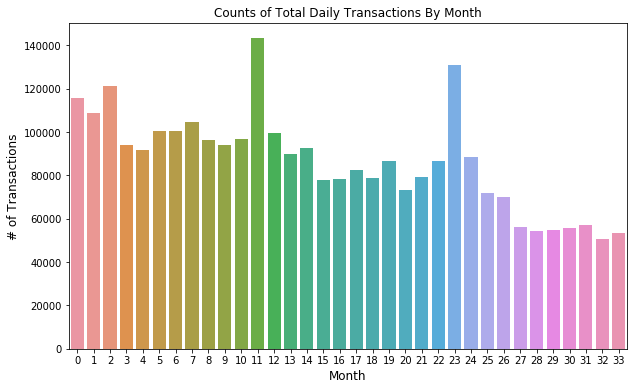

In [16]:
# Check how many total sales transactions there are in each month
monthly_sales_totals = sales.date_block_num.value_counts()
plt.figure(figsize=(10,6))
ax = sns.barplot(monthly_sales_totals.index, monthly_sales_totals.values)
plt.title("Counts of Total Daily Transactions By Month")
plt.ylabel("# of Transactions", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.show()

<b>FINDING:</b> December appears to be a high-volume month, while May appears to be a low-volume month. Other months also point to seasonality of the volume of purchases.

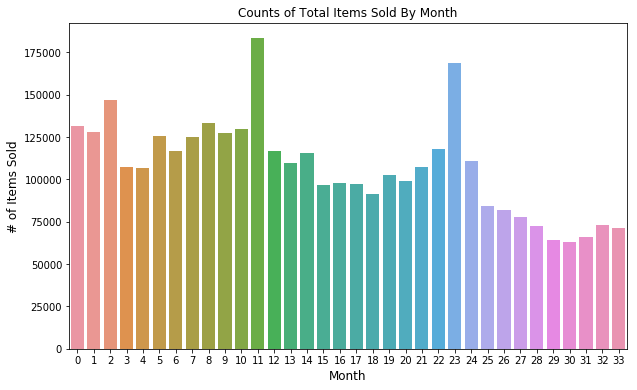

In [158]:
# Check how many total items were sold in each month
monthly_item_totals = sales.groupby("date_block_num")["item_cnt_day"].sum()
plt.figure(figsize=(10,6))
ax = sns.barplot(monthly_item_totals.index, monthly_item_totals.values)
plt.title("Counts of Total Items Sold By Month")
plt.ylabel("# of Items Sold", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.show()

**FINDING:** Looking at monthly totals from the number of items sold perspective, we still see that December is a high-volume month, but there are small differences in this chart and the chart above that looks at item-shop-level totals by month. We also see that there is an apparent downward trend over the whole period.

In [17]:
# Check distribution of month of transaction values (at item-date level) for each shop
sales.groupby('shop_id')['date_block_num'].describe().T

shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,9857.000000,5678.000000,25991.000000,25532.000000,38242.000000,38179.000000,82663.000000,58076.000000,3412.000000,3751.000000,21397.000000,499.0,34694.000000,17824.000000,36979.000000,59511.000000,52734.000000,22950.000000,53227.000000,63911.000000,1792.000000,58132.000000,45434.000000,6963.000000,53032.000000,186103.000000,53910.000000,105366.000000,142234.000000,49225.000000,50860.000000,235636.000000,7947.000000,5027.000000,5752.000000,58445.000000,306.0,39638.000000,46013.000000,13440.000000,4257.000000,41967.000000,109252.000000,39282.000000,39530.000000,35891.000000,66321.000000,56695.000000,21612.000000,15849.000000,65171.000000,44433.000000,43502.000000,52921.000000,143479.000000,34769.000000,69573.000000,117428.000000,71441.000000,42108.000000
mean,0.513747,0.525537,16.691855,15.927424,14.507740,16.520574,14.063269,14.853365,0.866061,18.944548,14.182128,25.0,17.484407,8.456744,14.700533,14.258725,13.562768,14.227015,13.454600,14.484893,26.671875,16.161907,14.645134,1.455838,14.689207,15.066350,14.201428,14.513154,14.811283,12.077583,11.074479,14.935341,2.489493,22.950467,25.989221,15.249722,33.0,13.845653,15.883055,23.520833,19.662203,13.466080,16.135860,11.758133,13.824817,13.846424,14.360851,16.592927,23.830326,22.462300,12.459576,12.461166,14.641879,14.886699,11.852585,20.666513,14.301511,15.116378,15.726432,14.301320
std,0.499836,0.499391,9.547010,9.418781,9.549651,9.146677,9.330895,9.427724,0.814302,9.239632,9.400191,0.0,9.643071,5.431443,9.883468,9.416648,9.712060,5.544127,9.855083,9.548045,5.992693,9.580284,9.705284,1.104115,9.148441,9.728439,9.559257,8.786275,9.454782,8.199808,7.322799,9.544102,1.689229,1.883741,4.242381,9.494405,0.0,10.126074,9.655999,5.709685,3.279946,9.151204,9.779877,7.241830,9.341741,9.315826,9.456020,9.641717,5.209350,6.223397,8.846800,8.930045,9.437649,9.377312,7.832074,7.897850,9.329751,8.872493,8.875159,9.560465
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.000000,0.000000,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,18.000000,0.000000,33.0,0.000000,0.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,2.000000,2.000000,0.000000
25%,0.000000,0.000000,9.000000,8.000000,7.000000,9.000000,6.000000,7.000000,0.000000,9.000000,6.000000,25.0,10.000000,4.000000,6.000000,6.000000,5.000000,10.000000,5.000000,6.000000,21.000000,8.000000,6.000000,0.000000,7.000000,7.000000,6.000000,7.000000,7.000000,5.000000,5.000000,7.000000,1.000000,22.000000,23.000000,7.000000,33.0,4.000000,8.000000,19.000000,17.000000,6.000000,8.000000,6.000000,6.000000,6.000000,6.000000,9.000000,19.000000,17.000000,5.000000,5.000000,7.000000,7.000000,5.000000,15.000000,6.000000,7.000000,8.000000,6.000000
50%,1.000000,1.000000,17.000000,16.000000,14.000000,16.000000,13.000000,14.000000,1.000000,21.000000,13.000000,25.0,18.000000,8.000000,14.000000,13.000000,12.000000,14.000000,11.000000,13.000000,21.000000,16.000000,13.000000,1.000000,13.000000,14.000000,13.000000,14.000000,14.000000,11.000000,11.000000,14.000000,2.000000,23.000000,26.000000,14.000000,33.0,12.000000,16.000000,23.000000,20.000000,12.000000,16.000000,11.000000,13.000000,12.000000,13.000000,17.000000,23.000000,23.000000,11.000000,11.000000,14.000000,14.000000,11.000000,22.000000,13.000000,14.000000,15.000000,13.000000
75%,1.000000,1.000000,24.000000,24.000000,23.000000,24.000000,22.000000,23.000000,2.000000,21.000000,22.000000,25.0,25.000000,13.000000,23.000000,22.000000,22.000000,19.000000,22.000000,23.000000,33.000000,24.000000,23.000000,2.000000,22.000000,23.0000

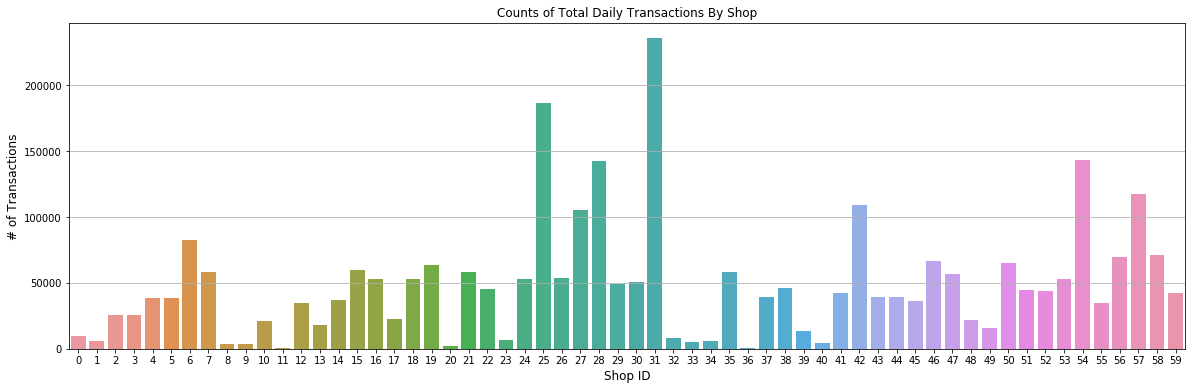

In [530]:
# Visualize differences in total transaction counts (at item-date level) across all shops
shop_tx_cts = sales.groupby('shop_id').size()
plt.figure(figsize=(20,6))
ax = sns.barplot(shop_tx_cts.index, shop_tx_cts.values)
ax.grid(axis='y')
plt.title("Counts of Total Daily Transactions By Shop")
plt.ylabel("# of Transactions", fontsize=12)
plt.xlabel("Shop ID", fontsize=12)
plt.show()

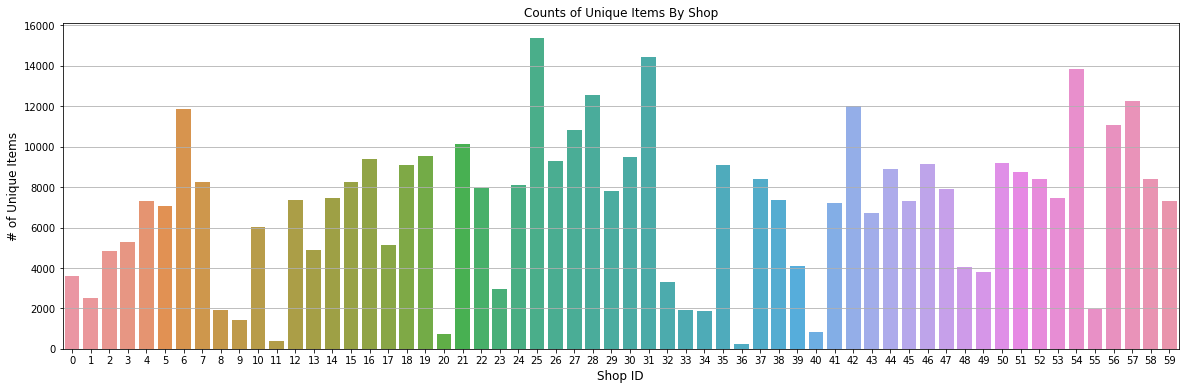

In [531]:
# Check the distribution of the number of unique items per shop
unique_items_by_shop = sales.groupby('shop_id')['item_id'].unique()
unique_item_cts_by_shop = unique_items_by_shop.map(len)
plt.figure(figsize=(20,6))
ax = sns.barplot(unique_item_cts_by_shop.index, unique_item_cts_by_shop.values)
ax.grid(axis='y')
plt.title("Counts of Unique Items By Shop")
plt.ylabel("# of Unique Items", fontsize=12)
plt.xlabel("Shop ID", fontsize=12)
plt.show()

In [20]:
# Check if there are changes in prices for same item
prices_by_item = sales.groupby('item_id')['item_price'].agg(['min','max']).reset_index()
prices_by_item.head(10)

,item_id,min,max
0,0,58.0,58.0
1,1,4490.0,4490.0
2,2,58.0,58.0
3,3,58.0,100.0
4,4,58.0,58.0
5,5,28.0,28.0
6,6,100.0,100.0
7,7,28.0,28.0
8,8,58.0,58.0
9,9,58.0,58.0


In [21]:
prices_by_item['price_changed'] = (prices_by_item['min'] != prices_by_item['max'])
prices_by_item.price_changed.value_counts()

True     15881
False     5926
Name: price_changed, dtype: int64

**FINDING:** About three-quarters of all items had different prices in the dataset.

In [22]:
prices_by_item.head(10)

,item_id,min,max,price_changed
0,0,58.0,58.0,False
1,1,4490.0,4490.0,False
2,2,58.0,58.0,False
3,3,58.0,100.0,True
4,4,58.0,58.0,False
5,5,28.0,28.0,False
6,6,100.0,100.0,False
7,7,28.0,28.0,False
8,8,58.0,58.0,False
9,9,58.0,58.0,False


In [34]:
# Determine if prices are always the same for one item on the same day, or if they vary by shop (and/or within one shop on same day)
prices_by_date_item = sales.groupby(['date','item_id'])['item_price'].agg(['min','max'])

In [35]:
prices_by_date_item.reset_index(inplace=True)
prices_by_date_item['diff_prices'] = (prices_by_date_item['min'] != prices_by_date_item['max'])
prices_by_date_item.head(10)

,date,item_id,min,max,diff_prices
0,2013-01-01,32,348.44,349.0,True
1,2013-01-01,33,499.00,499.0,False
2,2013-01-01,53,170.00,170.0,False
3,2013-01-01,59,110.00,249.0,True
4,2013-01-01,85,299.00,299.0,False
5,2013-01-01,98,268.00,399.0,True
6,2013-01-01,133,249.00,249.0,False
7,2013-01-01,154,299.00,299.0,False
8,2013-01-01,155,299.00,299.0,False
9,2013-01-01,354,258.00,258.0,False


In [36]:
prices_by_date_item.diff_prices.value_counts()

False    1426510
True      115104
Name: diff_prices, dtype: int64

**FINDING:** About 7.5% of date-item combinations show different prices.

In [28]:
prices_by_date_item_shop = sales.groupby(['date','item_id','shop_id'])['item_price'].agg(['min','max']).reset_index()

In [29]:
prices_by_date_item_shop.head()

,date,item_id,shop_id,min,max
0,2013-01-01,32,27,349.00,349.00
1,2013-01-01,32,28,349.00,349.00
2,2013-01-01,32,38,349.00,349.00
3,2013-01-01,32,42,348.44,348.44
4,2013-01-01,32,46,349.00,349.00


In [30]:
prices_by_date_item_shop['diff_prices'] = (prices_by_date_item_shop['min'] != prices_by_date_item_shop['max'])
prices_by_date_item_shop.diff_prices.value_counts()

False    2935799
True          22
Name: diff_prices, dtype: int64

<b>FINDING:</b> Based on the counts above, and the total number of rows in the sales dataset (2,935,843), there are 22 occasions when two different prices were used for same item in the same shop on the same day. On all other occasions, the same price was used in one shop for one item on the same day.

In [43]:
# Let's calculate the coefficient of variation of price for each shop-item combination to find those with a high level of volatility.
coef_of_var_by_shop_item = sales.groupby(['shop_id','item_id'])['item_price'].agg(variation)

In [69]:
# Identify the 10 highest shop-item combinations by coefficient of variation of price
coef_of_var_by_shop_item.sort_values(ascending=False).reset_index().rename(columns={'item_price':'coef_var'})[:10]

,shop_id,item_id,coef_var
0,7,11867,4.538900
1,28,11853,4.147582
2,14,11867,3.480296
3,15,11867,3.399952
4,56,11867,3.333000
5,42,11863,3.298889
6,17,11853,3.259849
7,25,20144,3.137431
8,38,11853,3.120867
9,25,11853,3.112585


In [64]:
# let's examine the prices over time for the combination with the highest coefficient of variation
sales[(sales.shop_id == 7) & (sales.item_id == 11867)][['date','shop_id','item_price']]

,date,shop_id,item_price
169627,2013-02-08,7,69.0
577400,2013-06-16,7,0.1
577401,2013-06-14,7,0.1
577402,2013-06-13,7,0.1
577403,2013-06-11,7,0.1
577404,2013-06-06,7,0.1
577405,2013-06-05,7,0.1
577406,2013-06-04,7,0.1
577600,2013-06-17,7,0.1
578189,2013-06-19,7,0.1


**FINDING:** It appears that in least in this case the large coefficient of variation is driven not by the shop itself, but by the long gap in times of transactions and the change in price of this item over that gap. Let's examine the trend in the price of this item across all shops.

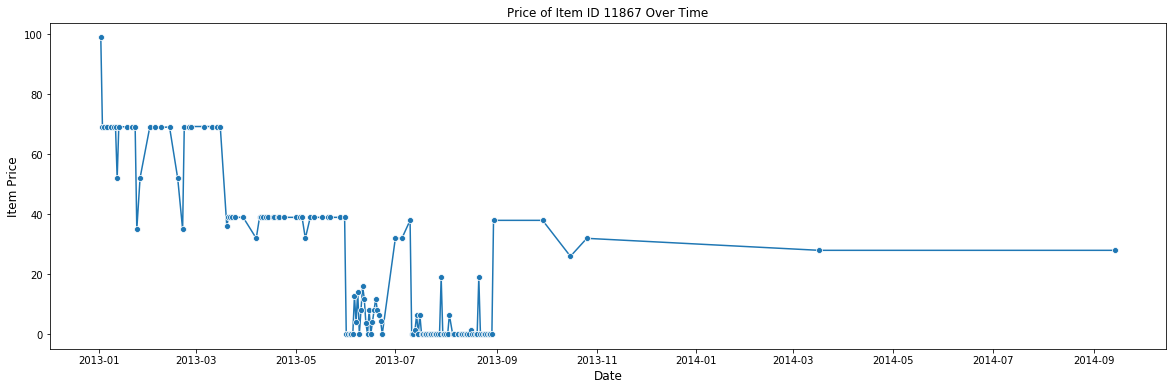

In [143]:
def plot_price_over_time(item):
    avg_item_prices_by_day = sales.groupby(['date','item_id'])['item_price'].mean().reset_index()
    plt.figure(figsize=(20,6))
    ax = sns.lineplot(avg_item_prices_by_day[avg_item_prices_by_day.item_id == item]['date'],
                      avg_item_prices_by_day[avg_item_prices_by_day.item_id == item]['item_price'],
                     marker="o")
    plt.title(f"Price of Item ID {item} Over Time")
    plt.ylabel("Item Price", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.show()
    
plot_price_over_time(11867)

In [66]:
# Given that a price may change dramatically over time for one product across all shops, let's calculate the coefficient of variation for each item separately.
coef_of_var_by_item = sales.groupby('item_id')['item_price'].agg(variation)

In [76]:
coef_of_var_by_item = coef_of_var_by_item.sort_values(ascending=False).reset_index().rename(columns={'item_price':'coef_var'})

In [77]:
coef_of_var_by_item[:10]

,item_id,coef_var
0,11860,4.016808
1,11872,3.369133
2,11866,3.057146
3,11855,2.517692
4,11856,2.338980
5,11863,2.308525
6,20144,2.299439
7,11859,2.259172
8,11853,2.228884
9,11365,2.177925


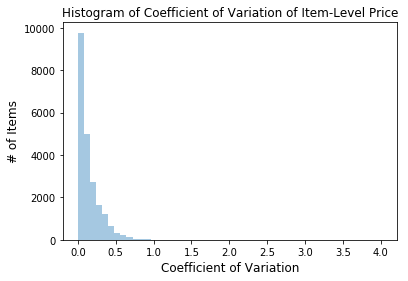

In [137]:
plt.figure(figsize=(6,4))
ax = sns.distplot(coef_of_var_by_item.coef_var, kde=False)
plt.title("Histogram of Coefficient of Variation of Item-Level Price")
plt.xlabel("Coefficient of Variation", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.show()

In [163]:
len(coef_of_var_by_item[coef_of_var_by_item.coef_var == 0.]) / len(coef_of_var_by_item)

0.2717476039803733

**FINDING:** Consistent with the earlier finding that about 3/4 of items had different prices in the dataset, 27.17% of items show a 0 for coefficient of variation (i.e., no differences in price).

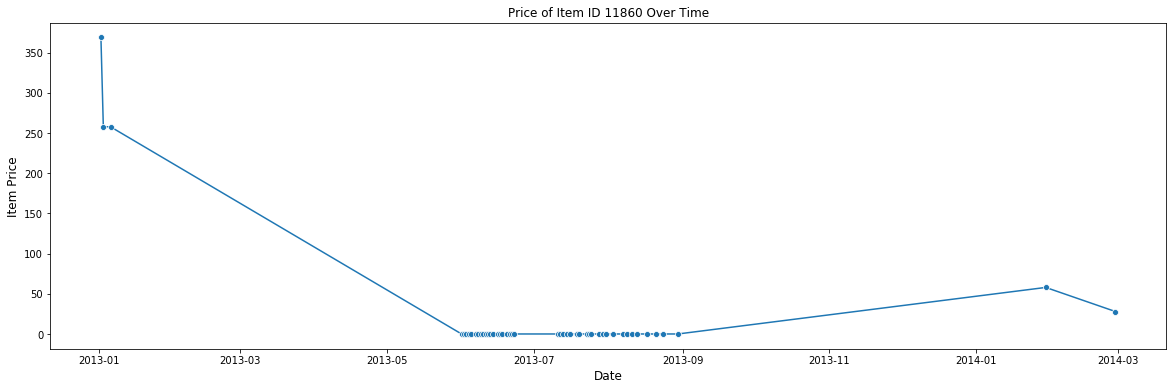

In [144]:
# Let's plot trends in prices for a couple of items with the highest coefficient of variation.
plot_price_over_time(11860)

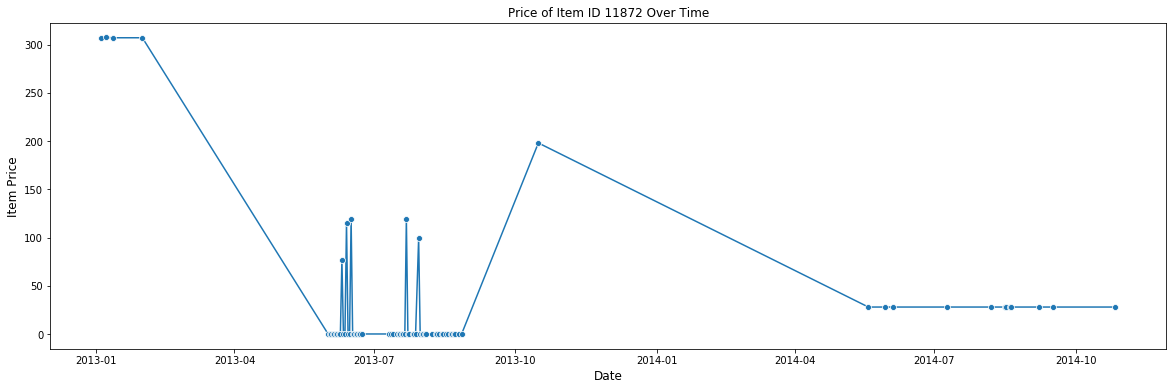

In [145]:
plot_price_over_time(11872)

**FINDING:** It appears that at least some of the large changes in price for an item are associated with a large gap between dates when that item was sold. Also, at least for these two items we can observe that there is a drop-off in price after the early part of the period.

In [185]:
# As we did with the price column, it is helpful to examine the volatility of the quantity sold for each item.
# This will not be possible with the coefficient of variation metric because of negative quantity values sometimes resulting in the 0 mean.
# Instead, let's utilize the mean absolute deviation metric.
quantity_mad_by_item = sales.groupby('item_id')['item_cnt_day'].mad()

quantity_mad_by_item = quantity_mad_by_item.sort_values(ascending=False).reset_index().rename(columns={'item_cnt_day':'quant_mad'})

quantity_mad_by_item[:10]

,item_id,quant_mad
0,19437,63.779614
1,19445,53.927083
2,9248,42.994356
3,9249,42.895996
4,4392,38.857143
5,4201,35.555556
6,4358,35.500000
7,3730,35.069252
8,19446,33.728532
9,10199,30.400000


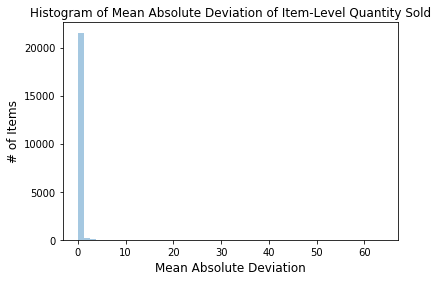

In [837]:
plt.figure(figsize=(6,4))
ax = sns.distplot(quantity_mad_by_item.quant_mad, kde=False)
plt.title("Histogram of Mean Absolute Deviation of Item-Level Quantity Sold")
plt.xlabel("Mean Absolute Deviation", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.show()

In [190]:
len(quantity_mad_by_item[quantity_mad_by_item.quant_mad == 0.]) / len(quantity_mad_by_item)

0.564405924703077

**FINDING:** 56.4% of items show a mean absolute deviation of 0.

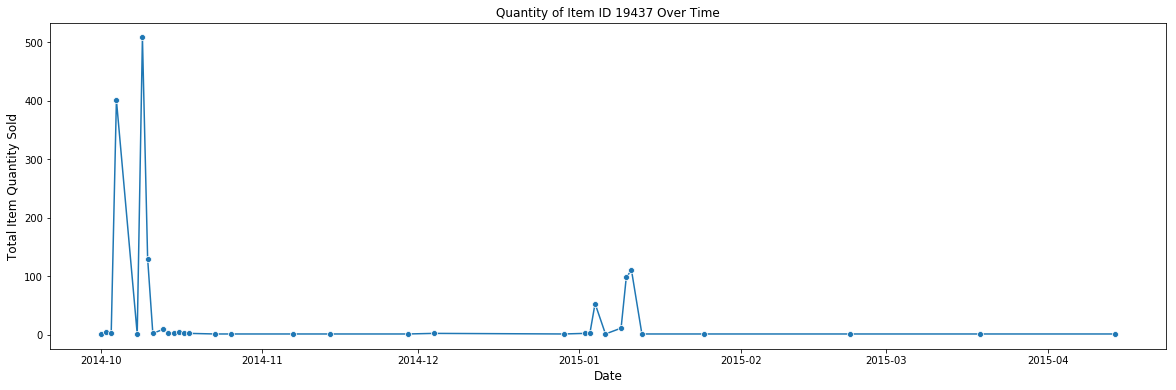

In [192]:
# Let's plot trends in total quantity sold for a couple of items with the highest mean absolute deviation.

def plot_quantity_over_time(item):
    total_item_qty_by_day = sales.groupby(['date','item_id'])['item_cnt_day'].sum().reset_index()
    plt.figure(figsize=(20,6))
    ax = sns.lineplot(total_item_qty_by_day[total_item_qty_by_day.item_id == item]['date'],
                      total_item_qty_by_day[total_item_qty_by_day.item_id == item]['item_cnt_day'],
                     marker="o")
    plt.title(f"Quantity of Item ID {item} Over Time")
    plt.ylabel("Total Item Quantity Sold", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.show()
    
plot_quantity_over_time(19437)

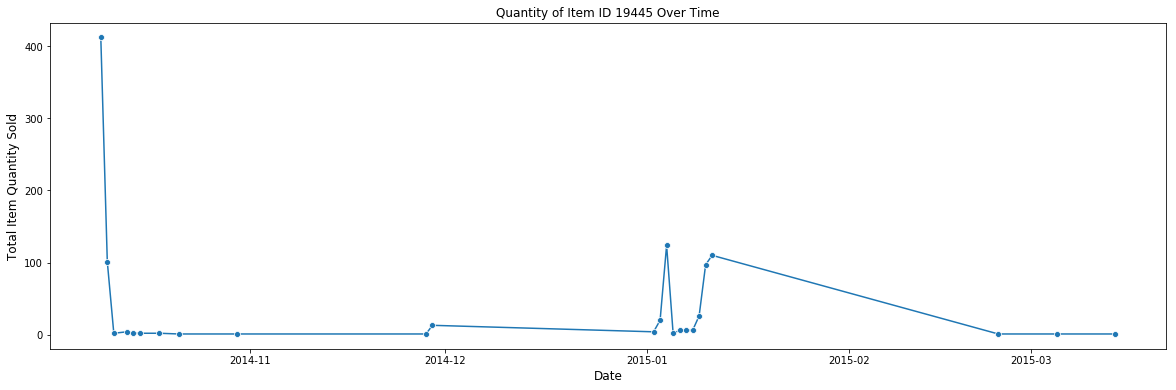

In [193]:
plot_quantity_over_time(19445)

**FINDING:** It appears that at least for some items there are random (maybe random, maybe not) short-term spikes in quantity sold. May need to investigate if these spikes are associated with anything.  It also appears that at least these two items had very large values of quantity sold at the beginning of their sales.

In [254]:
# Let's investigate how often items are bought and how much time passes between purchases
# Calculate number of unique days on which each item was bought, and percentage of all days in the dataset
n_days_by_item = sales.groupby("item_id")["date"].unique().map(lambda x: x.size).reset_index().rename(columns={'date':'n_unique_days'})
n_days_by_item['pct_of_all_days'] = n_days_by_item.n_unique_days / ((sales.date.max() - sales.date.min()).days + 1)
n_days_by_item.head()

,item_id,n_unique_days,pct_of_all_days
0,0,1,0.000967
1,1,6,0.005803
2,2,2,0.001934
3,3,2,0.001934
4,4,1,0.000967


In [256]:
# examine the items with the highest frequency of sales
n_days_by_item.sort_values(by='pct_of_all_days', ascending=False)[:10]

,item_id,n_unique_days,pct_of_all_days
5717,5822,1033,0.999033
2263,2308,1018,0.984526
7735,7894,1006,0.972921
5718,5823,999,0.966151
5716,5821,987,0.954545
7698,7856,981,0.948743
11924,12134,972,0.940039
7734,7893,970,0.938104
2749,2808,967,0.935203
1860,1905,967,0.935203


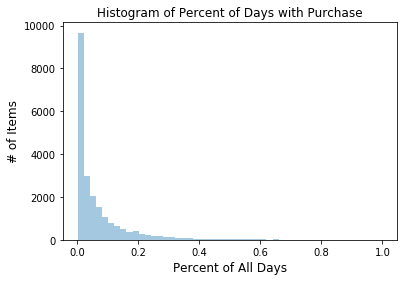

In [295]:
plt.figure(figsize=(6,4))
ax = sns.distplot(n_days_by_item.pct_of_all_days, kde=False)
plt.title("Histogram of Percent of Days with Purchase")
plt.xlabel("Percent of All Days", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.show()

**FINDING:** There are items that were purchased on nearly all of the days in the train dataset, but those are exceptions. Most items are not purchased frequently.

In [291]:
# examine which values of number of unique days are associated with the highest counts of items
n_days_by_item.n_unique_days.value_counts().sort_values(ascending=False)[:10]

1     2381
2     1067
3      692
4      569
5      477
6      440
8      367
7      359
10     324
9      318
Name: n_unique_days, dtype: int64

**FINDING:** 2,381 items in the train dataset were bought on just one day (each).

In [282]:
unique_item_dates = sales[['item_id','shop_id','date']].drop_duplicates(subset=['item_id','date']).sort_values(by=['item_id','date'])

In [283]:
avg_time_bw_sales_by_item = unique_item_dates.groupby("item_id")["date"].apply(lambda x: x.diff().mean()).reset_index().rename(columns={'date':'avg_gap'})

In [284]:
avg_time_bw_sales_by_item.avg_gap.isnull().sum()

2381

In [287]:
# Replace missing values with 0 for items that only had one day of purchase
avg_time_bw_sales_by_item.fillna(0, inplace=True)

In [288]:
avg_time_bw_sales_by_item[:10]

,item_id,avg_gap
0,0,0 days 00:00:00
1,1,40 days 04:48:00
2,2,80 days 00:00:00
3,3,52 days 00:00:00
4,4,0 days 00:00:00
5,5,0 days 00:00:00
6,6,0 days 00:00:00
7,7,0 days 00:00:00
8,8,6 days 00:00:00
9,9,0 days 00:00:00


In [292]:
# examine which values of average number of days between purchases are associated with the highest counts of items
avg_time_bw_sales_by_item.avg_gap.dt.days.value_counts().sort_values(ascending=False)[:10]

0    2381
2    1718
1    1524
3    1511
4    1199
5    1056
6     904
7     782
8     683
9     587
Name: avg_gap, dtype: int64

In [306]:
avg_time_bw_sales_by_item.avg_gap.dt.days.describe()

count    21807.000000
mean        23.343743
std         54.577716
min          0.000000
25%          2.000000
50%          7.000000
75%         21.000000
max        978.000000
Name: avg_gap, dtype: float64

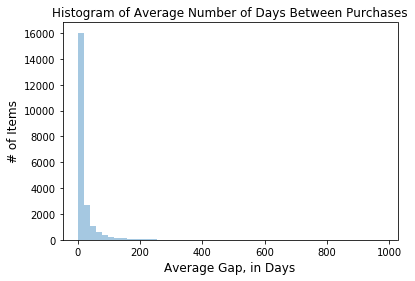

In [304]:
plt.figure(figsize=(6,4))
ax = sns.distplot(avg_time_bw_sales_by_item.avg_gap.dt.days, kde=False)
plt.title("Histogram of Average Number of Days Between Purchases")
plt.xlabel("Average Gap, in Days", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.show()

**FINDING:** Again, it is a highly skewed distribution.  The mean of average gap is 23.34 days, while the median is only 7 days.  The maximum value is 978 days, so there is one item that had a gap of almost 3 years between its purchases.  Whether that is an accurate value or not is not clear.

In [312]:
# Calculate number of unique days on which each shop sold an item, and percentage of all days in the dataset
n_days_by_shop = sales.groupby("shop_id")["date"].unique().map(lambda x: x.size).reset_index().rename(columns={'date':'n_unique_days'})
n_days_by_shop['pct_of_all_days'] = n_days_by_shop.n_unique_days / ((sales.date.max() - sales.date.min()).days + 1)
n_days_by_shop.head()

,shop_id,n_unique_days,pct_of_all_days
0,0,57,0.055126
1,1,56,0.054159
2,2,1018,0.984526
3,3,1028,0.994197
4,4,1010,0.976789


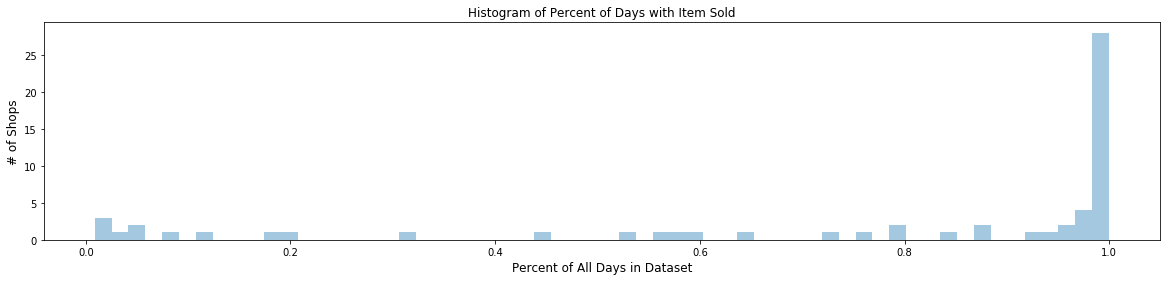

In [316]:
plt.figure(figsize=(20,4))
ax = sns.distplot(n_days_by_shop.pct_of_all_days, bins=60, kde=False)
plt.title("Histogram of Percent of Days with Item Sold")
plt.xlabel("Percent of All Days in Dataset", fontsize=12)
plt.ylabel("# of Shops", fontsize=12)
plt.show()

In [307]:
unique_shop_dates = sales[['item_id','shop_id','date']].drop_duplicates(subset=['shop_id','date']).sort_values(by=['shop_id','date'])

In [308]:
avg_time_bw_sales_by_shop = unique_shop_dates.groupby("shop_id")["date"].apply(lambda x: x.diff().mean()).reset_index().rename(columns={'date':'avg_gap'})

In [317]:
avg_time_bw_sales_by_shop.head()

,shop_id,avg_gap
0,0,1 days 00:00:00
1,1,1 days 00:26:10.909090
2,2,1 days 00:22:39.292035
3,3,1 days 00:07:00.642648
4,4,1 days 00:32:49.474727


In [324]:
shop_level_stats = avg_time_bw_sales_by_shop.merge(n_days_by_shop, on='shop_id')
shop_level_stats['avg_gap_hrs'] = shop_level_stats.avg_gap.dt.days * 24 + shop_level_stats.avg_gap.dt.seconds / 3600.
shop_level_stats.head()

,shop_id,avg_gap,n_unique_days,pct_of_all_days,avg_gap_hrs
0,0,1 days 00:00:00,57,0.055126,24.000000
1,1,1 days 00:26:10.909090,56,0.054159,24.436111
2,2,1 days 00:22:39.292035,1018,0.984526,24.377500
3,3,1 days 00:07:00.642648,1028,0.994197,24.116667
4,4,1 days 00:32:49.474727,1010,0.976789,24.546944


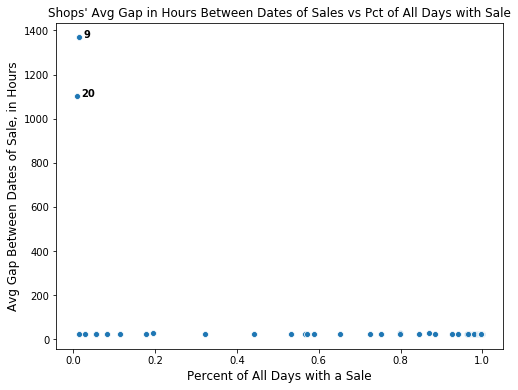

In [337]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=shop_level_stats, x="pct_of_all_days", y="avg_gap_hrs")

# display shop_id values for the two outlier shops in the plot
for line in range(shop_level_stats.shape[0]):
    if shop_level_stats.loc[line,'avg_gap_hrs'] > 200:
        ax.text(shop_level_stats.pct_of_all_days[line]+0.01, shop_level_stats.avg_gap_hrs[line], 
        shop_level_stats.shop_id[line], horizontalalignment='left', 
        size='medium', color='black', weight='semibold')

plt.title("Shops' Avg Gap in Hours Between Dates of Sales vs Pct of All Days with Sale")
plt.xlabel("Percent of All Days with a Sale", fontsize=12)
plt.ylabel("Avg Gap Between Dates of Sale, in Hours", fontsize=12)
plt.show()

In [407]:
shop_level_stats[shop_level_stats.avg_gap_hrs < 200].avg_gap_hrs.describe()

count    58.000000
mean     24.383597
std       1.043993
min      24.000000
25%      24.042222
50%      24.069722
75%      24.187222
max      29.963611
Name: avg_gap_hrs, dtype: float64

**FINDING:** Nearly all shops have just about a 1-day average gap between sales (i.e., they sell items just about every day), but there is a couple of shops with the average gap above 1,000 hours (over 40 days).  We'll need to examine those two shops more closely later.

In [341]:
# Let's also examine how each shop's overall span between first and last dates of sales looks.
shop_level_stats['first_date'] = sales.groupby('shop_id')['date'].min()
shop_level_stats['last_date'] = sales.groupby('shop_id')['date'].max()

In [342]:
shop_level_stats.head()

,shop_id,avg_gap,n_unique_days,pct_of_all_days,avg_gap_hrs,first_date,last_date
0,0,1 days 00:00:00,57,0.055126,24.000000,2013-01-03,2013-02-28
1,1,1 days 00:26:10.909090,56,0.054159,24.436111,2013-01-03,2013-02-28
2,2,1 days 00:22:39.292035,1018,0.984526,24.377500,2013-01-01,2015-10-31
3,3,1 days 00:07:00.642648,1028,0.994197,24.116667,2013-01-02,2015-10-31
4,4,1 days 00:32:49.474727,1010,0.976789,24.546944,2013-01-02,2015-10-31


In [343]:
shop_level_stats.dtypes

shop_id                      int64
avg_gap            timedelta64[ns]
n_unique_days                int64
pct_of_all_days            float64
avg_gap_hrs                float64
first_date          datetime64[ns]
last_date           datetime64[ns]
dtype: object

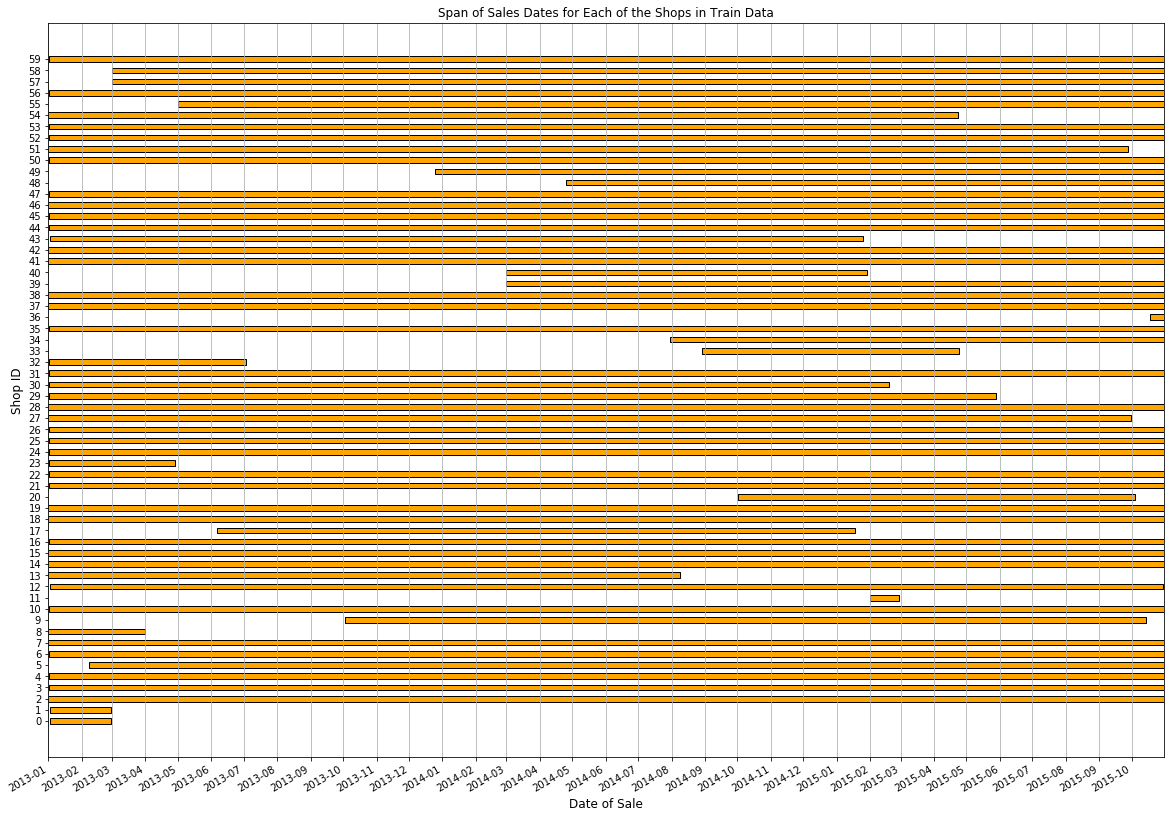

In [406]:
bdate = [t for t in shop_level_stats['first_date'] ]
edate = [t for t in shop_level_stats['last_date'] ]

# Now convert them to matplotlib's internal format...
edate, bdate = [mdates.date2num(item) for item in (edate, bdate)]

ypos = range(len(edate))

fig, ax = plt.subplots(figsize = (20, 15))

ax.grid(axis='x')

# Plot the data
ax.barh(ypos, edate - bdate, left=bdate, height=0.5, align='center', color="orange", edgecolor="black")
ax.axis('tight')
ax.set_yticks([i for i in shop_level_stats.index])
#ax.set_xticks([i for i in shop_level_stats.fir])

# Formatters for x-axis labels
months = mdates.MonthLocator()  # every month
date_fmt = mdates.DateFormatter('%Y-%m')
# We need to tell matplotlib that these are dates...
ax.xaxis_date()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(date_fmt)
fig.autofmt_xdate()
ax.set_xlim(shop_level_stats.first_date.min(), shop_level_stats.last_date.max())

plt.title("Span of Sales Dates for Each of the Shops in Train Data")
plt.xlabel("Date of Sale", fontsize=12)
plt.ylabel("Shop ID", fontsize=12)

plt.show()

**FINDING:** We can see that there are 18 shops that stopped selling before the last day in the train dataset.

In [413]:
#Let's dive a little deeper into quantity sold values
sales.item_cnt_day.max()

2169.0

In [414]:
#Let's look into this item with the highest quantity sold value
sales[sales.item_cnt_day == 2169.0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [424]:
# divide total revenue by quantity to get back the price
round(1971 / 2169, 6)

0.908714

**FINDING:** It appears that the price in this case was set based on the total amount or based on the quantity sold.

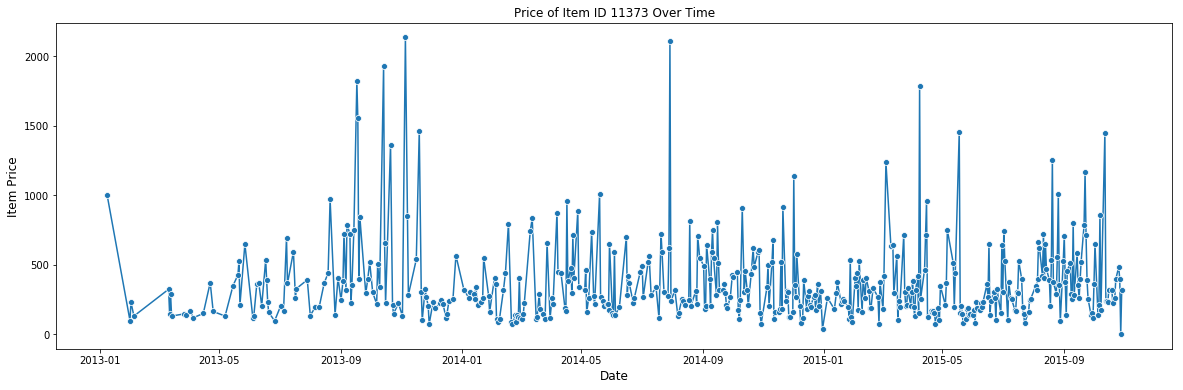

In [417]:
plot_price_over_time(11373)

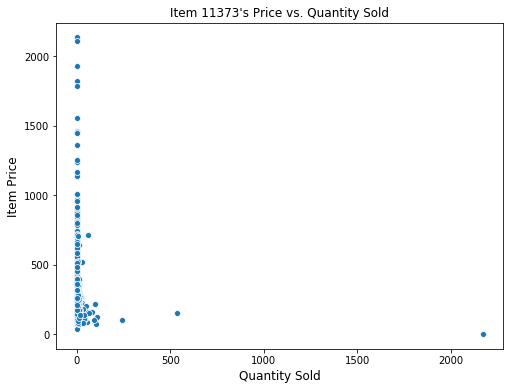

In [422]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=sales[sales.item_id == 11373], x="item_cnt_day", y="item_price")
plt.title("Item 11373's Price vs. Quantity Sold")
plt.xlabel("Quantity Sold", fontsize=12)
plt.ylabel("Item Price", fontsize=12)
plt.show()

**FINDING:** Item 11373 looks odd, as quantity sold is not dependent on price for most sales. The price is also very volatile with a very large range. We'll need to examine this item more closely later.

In [425]:
sales.item_cnt_day.min()

-22.0

In [426]:
#Let's look into this item with the largest negative quantity sold value
sales[sales.item_cnt_day == -22.0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1057907,2013-11-02,10,12,8023,15.0,-22.0


In [430]:
sales[(sales.shop_id == 12) & (sales.item_id == 8023)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
511574,2013-05-31,4,12,8023,20.0,1.0
885224,2013-09-25,8,12,8023,15.0,22.0
1057907,2013-11-02,10,12,8023,15.0,-22.0
1175066,2013-12-27,11,12,8023,15.0,1.0
1330814,2014-01-27,12,12,8023,15.0,20.0


**FINDING:** At least in this case, it appears that the negative value of quantity sold is either a return of the item or some type of accounting/inventory correction.

In [431]:
# Let's look into all of these rows with negative quantity sold to see if we can figure out what those mean
len(sales[sales.item_cnt_day < 0])

7356

In [444]:
neg_qty_df = sales[sales.item_cnt_day < 0]

In [464]:
#Make the db in memory
conn = sqlite3.connect(':memory:')

#write the tables
neg_qty_df.to_sql('neg_qty_tbl', conn, index=False)
sales.to_sql('sales_tbl', conn, index=False)

qry = '''
    select
        date,
        max(earlier_date) most_recent_earlier_date,
        date_block_num,
        shop_id,
        item_id,
        item_price,
        item_cnt_day
    from
        (select
            neg_qty_tbl.date,
            sales_tbl.date earlier_date,
            neg_qty_tbl.date_block_num,
            neg_qty_tbl.shop_id,
            neg_qty_tbl.item_id,
            neg_qty_tbl.item_price,
            neg_qty_tbl.item_cnt_day
        from
            neg_qty_tbl left join sales_tbl on
            neg_qty_tbl.shop_id = sales_tbl.shop_id and
            neg_qty_tbl.item_id = sales_tbl.item_id and
            neg_qty_tbl.item_price = sales_tbl.item_price and
            abs(neg_qty_tbl.item_cnt_day) = sales_tbl.item_cnt_day and
            neg_qty_tbl.date > sales_tbl.date)
    group by date, shop_id, item_id, item_price, item_cnt_day
    '''

neg_qty_history = pd.read_sql_query(qry, conn)

In [465]:
neg_qty_history.shape

(7356, 7)

In [466]:
neg_qty_history.head()

,date,most_recent_earlier_date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01 00:00:00,None,0,18,6724,299.5,-1.0
1,2013-01-01 00:00:00,None,0,19,13086,1499.0,-1.0
2,2013-01-01 00:00:00,None,0,19,20383,1229.0,-1.0
3,2013-01-01 00:00:00,None,0,27,12269,1499.0,-1.0
4,2013-01-01 00:00:00,None,0,37,9601,849.0,-1.0


In [467]:
len(neg_qty_history[neg_qty_history.most_recent_earlier_date.isnull()])

358

**FINDING:** Out of 7,356 shop-item-date combinations with negative quantity sold, 6,998 (95%) have a record with an earlier date with the positive value of that quantity (supporting the hypothesis that those negative quantities are returns or accounting/inventory adjustments).  Only 358 combinations do not show an earlier positive quantity sold (of exact same value).  (It is possible that the negative quantity captures multiple dates of returns/adjustments, not just one, or that the negative quantity is a subset of the positive quantity sold.)

In [469]:
neg_qty_history[neg_qty_history.most_recent_earlier_date.isnull()].date_block_num.value_counts().sort_index()

0     126
1      26
2      10
3       9
4       1
5       8
6       2
7      15
8       3
9      15
10      9
11      6
12     10
13      7
14      3
15      5
16      3
17      6
18      6
19      7
20      9
21      7
22      3
23      4
24      4
25      6
26      5
27      5
28      9
29      8
30      3
31      5
32      6
33      7
Name: date_block_num, dtype: int64

**FINDNG:** We can also see that among those 358 combinations, a lot of them are in the early months of the period covered by the training data, so it possible that we are just not able to observe the purchases/incorrect transactions that happened prior to these returns/adjustments. 

In [838]:
# Let's see if negative quantity values are associated with some set of items or shops
sales[sales.item_cnt_day < 0].shop_id.nunique()

54

In [846]:
# ten shops with highest count of item-dates with negative quantity sold
sales[sales.item_cnt_day < 0].shop_id.value_counts()[:10]

31    451
12    430
54    356
25    316
57    314
6     261
42    251
28    216
43    211
19    211
Name: shop_id, dtype: int64

In [847]:
# ten shops with lowest count of item-dates with negative quantity sold (among shops with at least 1 negative value)
sales[sales.item_cnt_day < 0].shop_id.value_counts()[-10:]

32    34
34    25
33    22
23    17
40    13
9      8
8      6
36     3
55     2
20     1
Name: shop_id, dtype: int64

**FINDING:** Nearly all shops had a negative quantity sold value, but there are shops where negative quantity was much more common.

In [839]:
sales[sales.item_cnt_day < 0].item_id.nunique()

3511

In [848]:
# ten items with highest count of shop-dates with negative quantity sold
sales[sales.item_cnt_day < 0].item_id.value_counts()[:10]

2331     56
3734     41
1915     32
5672     31
4332     27
16787    27
6675     24
5613     24
3732     24
4249     24
Name: item_id, dtype: int64

In [849]:
# ten items with lowest count of shop-dates with negative quantity sold (among items with at least 1 negative value)
sales[sales.item_cnt_day < 0].item_id.value_counts()[-10:]

11920    1
16735    1
22167    1
3736     1
6492     1
6484     1
7838     1
20764    1
1701     1
4102     1
Name: item_id, dtype: int64

**FINDING:** 3,511 out of 21,807 (16%) of items had a negative quantity sold.  Some items had multiple occurrences of this (up to 56 times).

In [844]:
sales[sales.item_cnt_day < 0].groupby(['shop_id','item_id']).size().reset_index() \
    .rename(columns={0:'count'}).sort_values(by='count', ascending=False).head(15)

,shop_id,item_id,count
840,12,3732,12
842,12,3734,8
874,12,5208,5
4264,42,2331,5
765,12,1590,5
1046,12,20384,5
846,12,3740,4
4682,44,3114,4
4503,43,3734,4
112,3,3556,4


**FINDING:** Shop 12 appears to have experienced multiple occasions of negative quantity sold with several items.

In [480]:
#Let's look into any interesting patterns in sales in shops that closed before the end of the period covered by the training data.
np.sort(shop_level_stats.last_date.dt.date.unique())

array([datetime.date(2013, 2, 28), datetime.date(2013, 4, 1),
       datetime.date(2013, 4, 28), datetime.date(2013, 7, 3),
       datetime.date(2014, 8, 9), datetime.date(2015, 1, 18),
       datetime.date(2015, 1, 25), datetime.date(2015, 1, 29),
       datetime.date(2015, 2, 18), datetime.date(2015, 2, 28),
       datetime.date(2015, 4, 23), datetime.date(2015, 4, 24),
       datetime.date(2015, 5, 28), datetime.date(2015, 9, 28),
       datetime.date(2015, 9, 30), datetime.date(2015, 10, 4),
       datetime.date(2015, 10, 14), datetime.date(2015, 10, 30),
       datetime.date(2015, 10, 31)], dtype=object)

In [483]:
# query to identify 18 shops that stopped sales before the end of the train period
closed_shops = shop_level_stats[shop_level_stats.last_date < datetime.datetime(2015,10,30)].shop_id.unique()
closed_shops

array([ 0,  1,  8,  9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51,
       54])

In [492]:
monthly_sales_of_closed_shops = sales[sales.shop_id.isin(closed_shops)] \
    .groupby(['shop_id','date_block_num'])['item_cnt_day'].sum().reset_index() \
    .rename(columns={'item_cnt_day':'total_qty_sold'})

In [503]:
monthly_sales_of_closed_shops = monthly_sales_of_closed_shops.merge(shop_level_stats[['shop_id','last_date']], \
                                                                    on="shop_id", how="left")
monthly_sales_of_closed_shops['month_before_closure'] = monthly_sales_of_closed_shops.last_date.apply(month_counter) \
    - monthly_sales_of_closed_shops.date_block_num

monthly_sales_of_closed_shops.head(10)

,shop_id,date_block_num,total_qty_sold,last_date,month_before_closure
0,0,0,5578.0,2013-02-28,1
1,0,1,6127.0,2013-02-28,0
2,1,0,2947.0,2013-02-28,1
3,1,1,3364.0,2013-02-28,0
4,8,0,1463.0,2013-04-01,3
5,8,1,1156.0,2013-04-01,2
6,8,2,977.0,2013-04-01,1
7,8,3,-1.0,2013-04-01,0
8,9,9,6526.0,2015-10-14,24
9,9,21,6155.0,2015-10-14,12


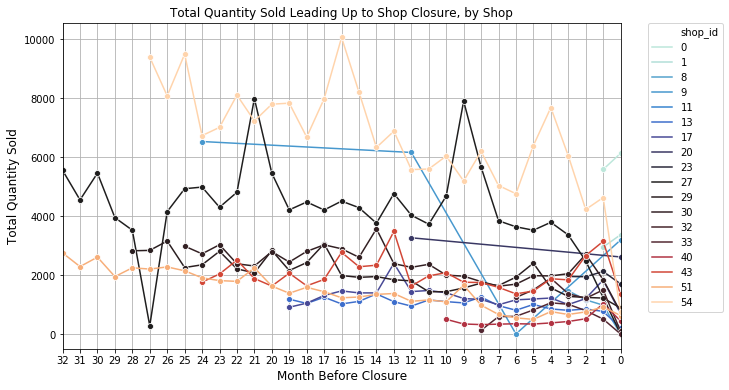

In [528]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.lineplot(data=monthly_sales_of_closed_shops, x='month_before_closure', 
             y='total_qty_sold', marker = "o", hue='shop_id', palette="icefire", legend="full")

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.grid(True)
ax.set_xlim(32, 0)
ax.set_xticks(range(33))
ax.set_xlabel("Month Before Closure", fontsize=12)
ax.set_ylabel("Total Quantity Sold", fontsize=12)
ax.set_title("Total Quantity Sold Leading Up to Shop Closure, by Shop")
plt.show()

**FINDING:** It is evident that there are some closed shops that had declining sales for several months leading up to closure (and very low (close to 0) sales in the month of closure).  It can also be seen that many shops had a spike in sales in the month just prior to the month of closure. And there are shops that go months without sales. The store with only four data points appears to only be in operation every 6 or 12 months.

In [534]:
#Let's see if we can identify and learn anything about items when they first go on sale
earliest_dts_by_item = sales.groupby('item_id')['date'].min().reset_index().rename(columns={'date':'earliest_dt'})
earliest_dts_by_item.head()

,item_id,earliest_dt
0,0,2014-09-01
1,1,2014-04-02
2,2,2014-08-24
3,3,2014-07-05
4,4,2014-09-19


In [556]:
earliest_dts_by_item.earliest_dt.describe()

count                   21807
unique                   1027
top       2013-01-02 00:00:00
freq                     2053
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: earliest_dt, dtype: object

In [585]:
earliest_dts_cts = earliest_dts_by_item.earliest_dt.value_counts().sort_index()

In [587]:
earliest_dts_cts.head(15)

2013-01-01    1117
2013-01-02    2053
2013-01-03    1053
2013-01-04     608
2013-01-05     459
2013-01-06     369
2013-01-07     245
2013-01-08     238
2013-01-09     120
2013-01-10     135
2013-01-11     163
2013-01-12     182
2013-01-13     123
2013-01-14      76
2013-01-15      91
Name: earliest_dt, dtype: int64

In [612]:
# Let's ignore the items that show the earliest date in the first few days of the period, as those dates are likely not real, but left-censored.
earliest_dts_lmtd = earliest_dts_cts[earliest_dts_cts.index > datetime.datetime(2013,1,8)]

In [590]:
earliest_dts_lmtd.describe()

count    1019.000000
mean       15.372915
std        16.765466
min         1.000000
25%         7.000000
50%        11.000000
75%        18.000000
max       182.000000
Name: earliest_dt, dtype: float64

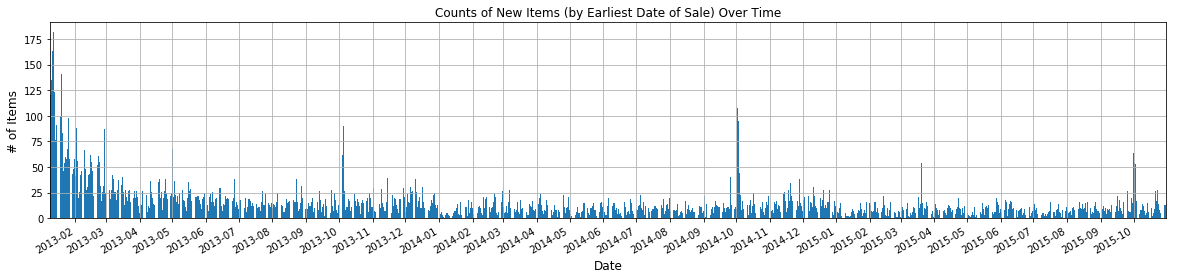

In [611]:
fig, ax = plt.subplots(figsize = (20, 4))
ax.bar(earliest_dts_lmtd.index, earliest_dts_lmtd.values)

months = mdates.MonthLocator()  # every month
date_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis_date()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(date_fmt)
fig.autofmt_xdate()
ax.set_xlim(earliest_dts_lmtd.index.min(), earliest_dts_lmtd.index.max())

ax.set_title("Counts of New Items (by Earliest Date of Sale) Over Time")
ax.set_ylabel("# of Items", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.grid(True)

plt.show()

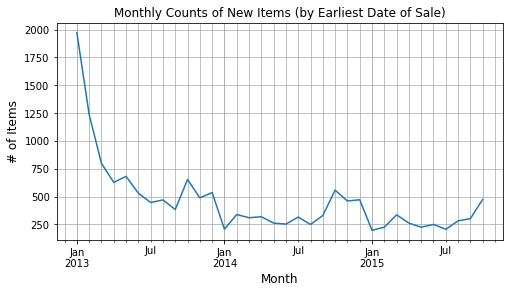

In [643]:
plt.figure(figsize=(8,4))

ax = earliest_dts_lmtd.resample('MS').sum().plot(kind='line')
ax.set_title("Monthly Counts of New Items (by Earliest Date of Sale)")
ax.set_ylabel("# of Items", fontsize=12)
ax.set_xlabel("Month", fontsize=12)
ax.grid(which='both')

plt.show()

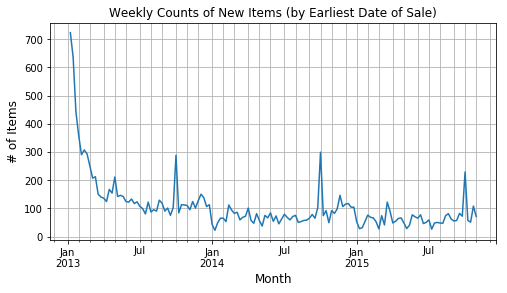

In [644]:
plt.figure(figsize=(8,4))

ax = earliest_dts_lmtd.resample('W').sum().plot(kind='line')
ax.set_title("Weekly Counts of New Items (by Earliest Date of Sale)")
ax.set_ylabel("# of Items", fontsize=12)
ax.set_xlabel("Month", fontsize=12)
ax.grid(which='both')

plt.show()

**FINDING:** While new items are introduced on a regular basis, it appears that at the beginning of each October there is a spike in the number of new items and there is a smaller bump around December, followed by a sharp drop in January.  We might need to study what kinds of items are introduced in different months.

In [645]:
#Let's see if we can identify and learn anything about items when they are removed from sale
latest_dts_by_item = sales.groupby('item_id')['date'].max().reset_index().rename(columns={'date':'latest_dt'})
latest_dts_by_item.head()

,item_id,latest_dt
0,0,2014-09-01
1,1,2014-10-20
2,2,2014-11-12
3,3,2014-08-26
4,4,2014-09-19


In [646]:
latest_dts_by_item.latest_dt.describe()

count                   21807
unique                   1034
top       2015-10-31 00:00:00
freq                     1349
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: latest_dt, dtype: object

In [647]:
latest_dts_cts = latest_dts_by_item.latest_dt.value_counts().sort_index()

In [650]:
latest_dts_cts.tail(20)

2015-10-12      57
2015-10-13      61
2015-10-14      69
2015-10-15      65
2015-10-16     108
2015-10-17     121
2015-10-18      94
2015-10-19      90
2015-10-20     116
2015-10-21     137
2015-10-22     134
2015-10-23     164
2015-10-24     250
2015-10-25     230
2015-10-26     169
2015-10-27     223
2015-10-28     238
2015-10-29     338
2015-10-30     598
2015-10-31    1349
Name: latest_dt, dtype: int64

In [651]:
# Let's ignore the items that show the latest date in the last few days of the period, as those dates are likely not real, but right-censored.
latest_dts_lmtd = latest_dts_cts[latest_dts_cts.index < datetime.datetime(2015,10,20)]

In [652]:
latest_dts_lmtd.describe()

count    1022.000000
mean       17.476517
std        12.000201
min         1.000000
25%        11.000000
50%        15.000000
75%        20.000000
max       129.000000
Name: latest_dt, dtype: float64

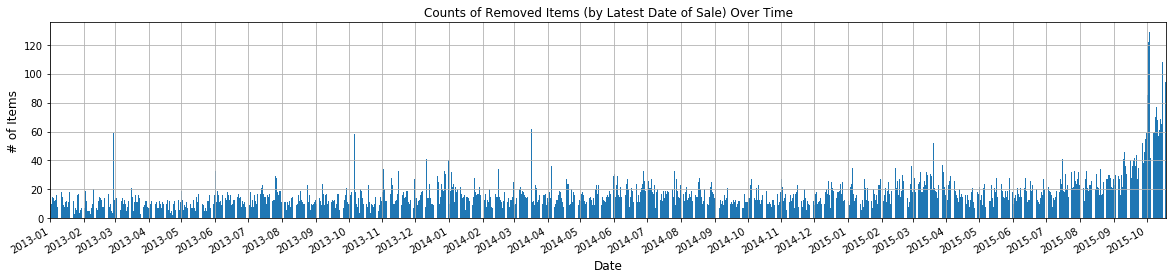

In [653]:
fig, ax = plt.subplots(figsize = (20, 4))
ax.bar(latest_dts_lmtd.index, latest_dts_lmtd.values)

months = mdates.MonthLocator()  # every month
date_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis_date()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(date_fmt)
fig.autofmt_xdate()
ax.set_xlim(latest_dts_lmtd.index.min(), latest_dts_lmtd.index.max())

ax.set_title("Counts of Removed Items (by Latest Date of Sale) Over Time")
ax.set_ylabel("# of Items", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.grid(True)

plt.show()

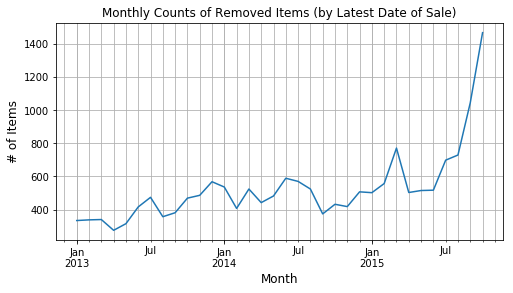

In [654]:
plt.figure(figsize=(8,4))

ax = latest_dts_lmtd.resample('MS').sum().plot(kind='line')
ax.set_title("Monthly Counts of Removed Items (by Latest Date of Sale)")
ax.set_ylabel("# of Items", fontsize=12)
ax.set_xlabel("Month", fontsize=12)
ax.grid(which='both')

plt.show()

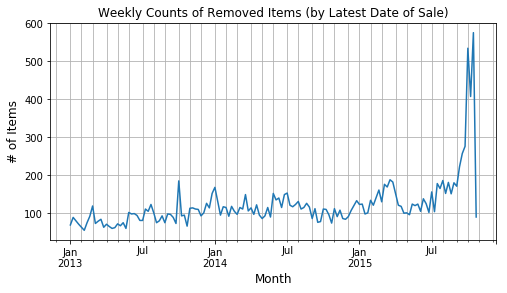

In [655]:
plt.figure(figsize=(8,4))

ax = latest_dts_lmtd.resample('W').sum().plot(kind='line')
ax.set_title("Weekly Counts of Removed Items (by Latest Date of Sale)")
ax.set_ylabel("# of Items", fontsize=12)
ax.set_xlabel("Month", fontsize=12)
ax.grid(which='both')

plt.show()

**FINDING:** End dates of sales for items are more random than start dates, though there appear to be spikes in March (looking at the daily and monthly trends). There may or may not also be a spike at the end (October 2015), given that there is a spike, followed by a decline, then by another increase.

In [656]:
item_level_stats = sales.groupby('item_id')['date'].min().reset_index().rename(columns={'date':'earliest_dt'})

In [658]:
item_level_stats['latest_dt'] = sales.groupby('item_id')['date'].max().values

In [675]:
item_level_stats['duration'] = item_level_stats.latest_dt - item_level_stats.earliest_dt + datetime.timedelta(days=1)

In [676]:
item_level_stats.head()

,item_id,earliest_dt,latest_dt,duration
0,0,2014-09-01,2014-09-01,1 days
1,1,2014-04-02,2014-10-20,202 days
2,2,2014-08-24,2014-11-12,81 days
3,3,2014-07-05,2014-08-26,53 days
4,4,2014-09-19,2014-09-19,1 days


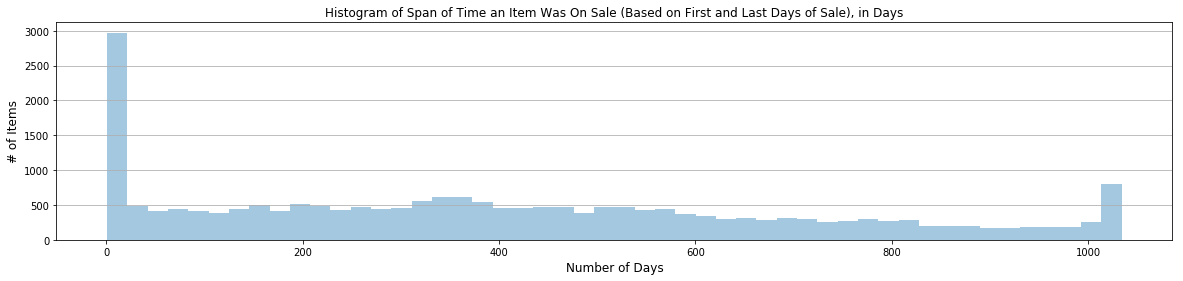

In [680]:
plt.figure(figsize=(20,4))
ax = sns.distplot(item_level_stats.duration.dt.days, bins=50, kde=False)
plt.title("Histogram of Span of Time an Item Was On Sale (Based on First and Last Days of Sale), in Days")
plt.xlabel("Number of Days", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.grid(axis="y")
plt.show()

In [682]:
item_level_stats.duration.dt.days.value_counts().sort_index().head()

1    2381
2      79
3      61
4      40
5      26
Name: duration, dtype: int64

In [683]:
item_level_stats.duration.dt.days.value_counts().sort_index().tail()

1030     57
1031     70
1032     80
1033    104
1034     65
Name: duration, dtype: int64

**FINDING:** 2,381 items were only sold on one day each.

In [702]:
# saving item_id values of items only sold on one day each to an array for later investigation
items_sold_one_day = item_level_stats[item_level_stats.duration.dt.days == 1]['item_id'].values

In [725]:
# Let's investigate if the day of the week of sales exhibits any patterns
sales['day_of_week'] = sales.date.dt.strftime('%A')

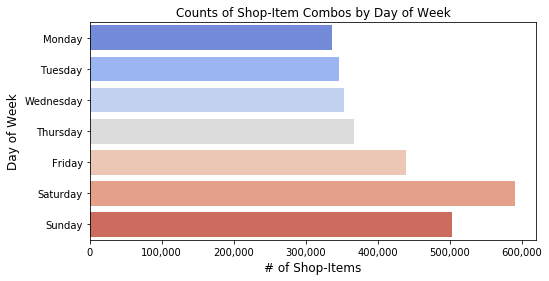

In [741]:
fig, ax = plt.subplots(figsize=(8, 4))

sort_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax = sns.countplot(y='day_of_week', data=sales, palette='coolwarm', order=sort_order)

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title("Counts of Shop-Item Combos by Day of Week")
plt.xlabel("# of Shop-Items", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.show()

**FINDING:** Sale volume increases steadily from Monday to Thursday, then jumps to a high on Saturday and comes down slightly on Sunday.

In [757]:
days_of_week_by_shop = sales.groupby('shop_id')['day_of_week'].unique().apply(lambda d: np.sort(d))

In [759]:
days_of_week_by_shop[days_of_week_by_shop.map(len) < 7]

shop_id
9     [Friday, Saturday, Sunday, Thursday, Wednesday]
20       [Friday, Monday, Saturday, Sunday, Thursday]
Name: day_of_week, dtype: object

In [760]:
shop_level_stats[shop_level_stats.shop_id.isin([9,20])]

,shop_id,avg_gap,n_unique_days,pct_of_all_days,avg_gap_hrs,first_date,last_date,duration
9,9,57 days 00:00:00,14,0.013540,1368.0,2013-10-03,2015-10-14,741 days
20,20,45 days 21:00:00,9,0.008704,1101.0,2014-10-02,2015-10-04,367 days


**FINDING:** Only two shops did not sell on every day of the week and those two are the odd shops that had very few days with sale while having a long span between first and last dates of sale.

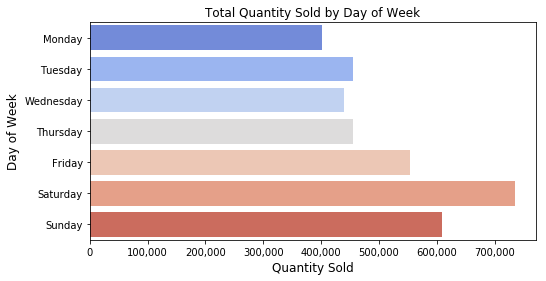

In [815]:
# total quantity sold by day of week
qty_sold_by_dow = sales.groupby('day_of_week')['item_cnt_day'].sum()

fig, ax = plt.subplots(figsize=(8, 4))

sort_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax = sns.barplot(y=qty_sold_by_dow.index, x=qty_sold_by_dow.values, palette='coolwarm', order=sort_order)

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title("Total Quantity Sold by Day of Week")
plt.xlabel("Quantity Sold", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.show()

**FINDING:** There is a slightly different pattern of quantity sold by day of week compared to count of shop-items sold by day of week.

In [792]:
# calculate relative shares of quantity sold each day of the week for each shop
total_qty_by_shop_dow = sales.groupby(['shop_id','day_of_week'])['item_cnt_day'].sum()
shop_pcts = total_qty_by_shop_dow.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index() \
    .rename(columns={'item_cnt_day':'pct_of_all_sales'})
shop_pcts['dow_num'] = shop_pcts.day_of_week.apply(lambda x: time.strptime(x, '%A').tm_wday)
shop_pcts.sort_values(by='dow_num', inplace=True)
shop_pcts.head(10)

,shop_id,day_of_week,pct_of_all_sales,dow_num
207,30,Monday,11.006444,0
256,37,Monday,10.067883,0
90,13,Monday,10.529778,0
263,38,Monday,9.967338,0
270,39,Monday,10.260577,0
83,12,Monday,18.364681,0
277,40,Monday,11.592151,0
284,41,Monday,10.037710,0
291,42,Monday,12.309826,0
69,10,Monday,12.000979,0


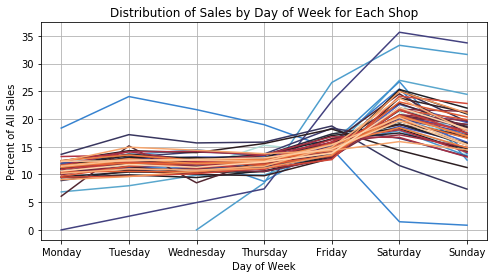

In [794]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(data=shop_pcts, x='dow_num', y='pct_of_all_sales', hue='shop_id', sort=True, legend=False,
                 palette='icefire')
ax.set_xticks(range(7))
ax.set_xticklabels(sort_order)
ax.set_xlabel("Day of Week")
ax.set_ylabel("Percent of All Sales")
ax.set_title("Distribution of Sales by Day of Week for Each Shop")
ax.grid(True)
plt.show()

In [779]:
shop_pcts[shop_pcts.pct_of_all_sales == shop_pcts.pct_of_all_sales.max()]

,shop_id,day_of_week,pct_of_all_sales
140,20,Saturday,35.660763


In [798]:
shop_pcts[shop_pcts.shop_id.isin([9,20])].sort_values(by=['shop_id','dow_num'])

,shop_id,day_of_week,pct_of_all_sales,dow_num
67,9,Wednesday,-0.012606,2
66,9,Thursday,8.464641,3
63,9,Friday,26.591453,4
64,9,Saturday,33.303920,5
65,9,Sunday,31.652590,6
139,20,Monday,-0.017030,0
142,20,Thursday,7.391008,3
138,20,Friday,23.228883,4
140,20,Saturday,35.660763,5
141,20,Sunday,33.736376,6


In [806]:
shop_w_highest_tue_val = shop_pcts[shop_pcts.dow_num == 1].sort_values(by='pct_of_all_sales', ascending=False)['shop_id'].values[0]
shop_pcts[shop_pcts.shop_id == shop_w_highest_tue_val]

,shop_id,day_of_week,pct_of_all_sales,dow_num
83,12,Monday,18.364681,0
87,12,Tuesday,24.053458,1
88,12,Wednesday,21.689485,2
86,12,Thursday,18.975748,3
82,12,Friday,14.630229,4
84,12,Saturday,1.454857,5
85,12,Sunday,0.831541,6


In [807]:
shop_level_stats[shop_level_stats.shop_id == 12]

,shop_id,avg_gap,n_unique_days,pct_of_all_days,avg_gap_hrs,first_date,last_date,duration
12,12,1 days 05:57:49.090909,826,0.798839,29.963611,2013-01-03,2015-10-30,1030 days


**FINDING:** Besides the two weird stores (shops 9 and 20), shop 12 shows that they had almost no sales on Saturdays and Sundays.

In [826]:
# Let's investigate if certain items are more likely to be sold at certain shops
n_shops_by_item = sales.groupby('item_id')['shop_id'].nunique().reset_index()

In [831]:
n_items_by_n_shops = n_shops_by_item.groupby('shop_id').item_id.nunique().reset_index()

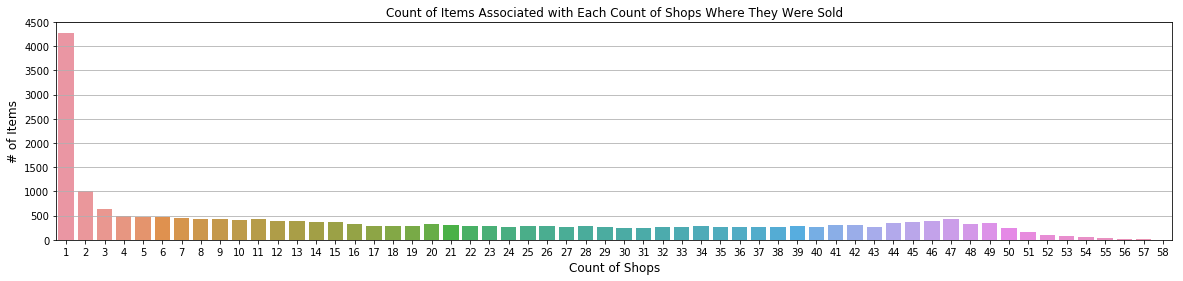

In [836]:
fig, ax = plt.subplots(figsize=(20, 4))
ax = sns.barplot(x=n_items_by_n_shops.shop_id, y=n_items_by_n_shops.item_id)
plt.title("Count of Items Associated with Each Count of Shops Where They Were Sold")
plt.xlabel("Count of Shops", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.grid(axis="y")
plt.show()

**FINDING:** Over 4,000 items were sold at one shop each.  Only a small share of items were sold at all or nearly all shops.

In [855]:
# Let's look into each item's sales to see how much of its total quantity sold happened when it first went on sale
item_qty_by_date = sales[['item_id','date','item_cnt_day']].sort_values(by=['item_id','date']).reset_index(drop=True)

In [856]:
item_qty_by_date['running_qty_total'] = item_qty_by_date.groupby('item_id').item_cnt_day.cumsum()

In [894]:
# create boolean flag for whether date of sale is within one week of item's first day of sale
item_qty_by_date['first_week'] = (item_qty_by_date.date - item_qty_by_date.groupby('item_id').date \
                                  .transform('first')).astype('timedelta64[D]') <= 7.

In [896]:
# create column for running percentage of total quantity sold by day for each item
item_qty_by_date['running_qty_pct'] = item_qty_by_date.running_qty_total / item_qty_by_date.groupby('item_id') \
    .running_qty_total.transform(max)

In [897]:
item_qty_by_date.head(10)

,item_id,date,item_cnt_day,running_qty_total,first_week,running_qty_pct
0,0,2014-09-01,1.0,1.0,True,1.000000
1,1,2014-04-02,1.0,1.0,True,0.166667
2,1,2014-04-04,1.0,2.0,True,0.333333
3,1,2014-07-06,1.0,3.0,False,0.500000
4,1,2014-08-04,1.0,4.0,False,0.666667
5,1,2014-09-11,1.0,5.0,False,0.833333
6,1,2014-10-20,1.0,6.0,False,1.000000
7,2,2014-08-24,1.0,1.0,True,0.500000
8,2,2014-11-12,1.0,2.0,False,1.000000
9,3,2014-07-05,1.0,1.0,True,0.500000


In [881]:
item_level_stats['qty_sold_first_week'] = item_qty_by_date[item_qty_by_date.first_week == True] \
    .groupby('item_id').running_qty_total.max().values

In [883]:
item_level_stats['pct_sold_first_week'] = item_level_stats.qty_sold_first_week / item_qty_by_date.groupby('item_id') \
    .running_qty_total.max().values

In [885]:
item_level_stats.head(10)

,item_id,earliest_dt,latest_dt,duration,qty_sold_first_week,pct_sold_first_week
0,0,2014-09-01,2014-09-01,1 days,1.0,1.000000
1,1,2014-04-02,2014-10-20,202 days,2.0,0.333333
2,2,2014-08-24,2014-11-12,81 days,1.0,0.500000
3,3,2014-07-05,2014-08-26,53 days,1.0,0.500000
4,4,2014-09-19,2014-09-19,1 days,1.0,1.000000
5,5,2014-12-14,2014-12-14,1 days,1.0,1.000000
6,6,2014-07-19,2014-07-19,1 days,1.0,1.000000
7,7,2014-12-14,2014-12-14,1 days,1.0,1.000000
8,8,2014-08-26,2014-09-01,7 days,2.0,1.000000
9,9,2014-08-07,2014-08-07,1 days,1.0,1.000000


In [889]:
item_level_stats[item_level_stats.pct_sold_first_week < 0.]

,item_id,earliest_dt,latest_dt,duration,qty_sold_first_week,pct_sold_first_week
249,257,2013-01-07,2015-08-04,940 days,-1.0,-0.009709
250,258,2013-01-07,2015-08-24,960 days,-1.0,-0.006944
5748,5856,2013-01-02,2014-11-18,686 days,-1.0,-0.090909
6128,6241,2013-01-02,2015-05-21,870 days,-1.0,-0.038462
12073,12283,2013-01-04,2013-10-25,295 days,-1.0,-0.142857
13218,13469,2013-01-02,2013-02-28,58 days,-1.0,-0.333333
13250,13501,2013-01-09,2013-09-10,245 days,-1.0,-0.045455
17848,18150,2013-01-02,2014-05-13,497 days,-1.0,-0.066667


**FINDING:** There is a few items with negative quantity sold in the first week, but these are all probably caused by left-censoring of the training period, given that they all show the earliest date of sale in January 2013.

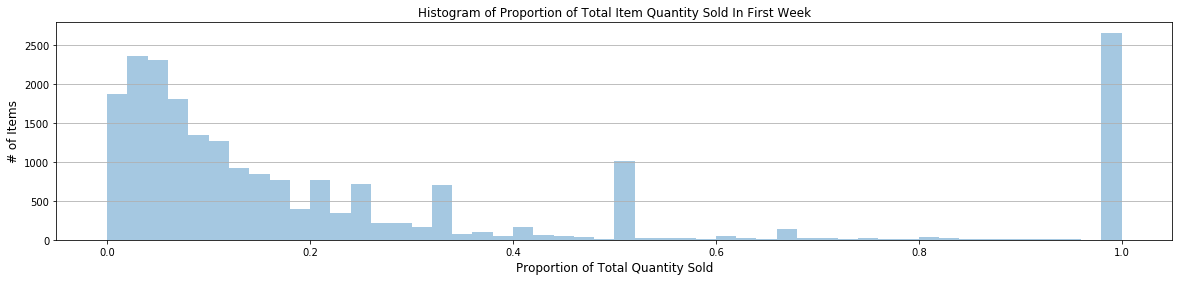

In [892]:
# plot histogram of proportion of total quantity sold in the first week (with the items with negative quantity removed)
fig, ax = plt.subplots(figsize=(20,4))
ax = sns.distplot(item_level_stats[item_level_stats.pct_sold_first_week >= 0.].pct_sold_first_week, kde=False)
plt.title("Histogram of Proportion of Total Item Quantity Sold In First Week")
plt.xlabel("Proportion of Total Quantity Sold", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.grid(axis="y")
plt.show()

**FINDING:** It appears that there are large groups of items that had either right around 50% or around 100% of their sales in the first week.

In [921]:
item_qty_by_date['ge_50pct'] = item_qty_by_date.running_qty_pct.ge(0.5)

In [923]:
item_qty_by_date.head(15)

,item_id,date,item_cnt_day,running_qty_total,first_week,running_qty_pct,ge_50pct
0,0,2014-09-01,1.0,1.0,True,1.000000,True
1,1,2014-04-02,1.0,1.0,True,0.166667,False
2,1,2014-04-04,1.0,2.0,True,0.333333,False
3,1,2014-07-06,1.0,3.0,False,0.500000,True
4,1,2014-08-04,1.0,4.0,False,0.666667,True
5,1,2014-09-11,1.0,5.0,False,0.833333,True
6,1,2014-10-20,1.0,6.0,False,1.000000,True
7,2,2014-08-24,1.0,1.0,True,0.500000,True
8,2,2014-11-12,1.0,2.0,False,1.000000,True
9,3,2014-07-05,1.0,1.0,True,0.500000,True


In [926]:
# for each item, identify the first date when item reached at least 50 of its sales
item_dts_ge_50pct = item_qty_by_date[item_qty_by_date.index.isin(item_qty_by_date.groupby('item_id'). \
                                                                 ge_50pct.idxmax().values)]['date']

In [927]:
item_level_stats['item_dts_ge_50pct'] = item_dts_ge_50pct.values

In [929]:
item_level_stats.head(10)

,item_id,earliest_dt,latest_dt,duration,qty_sold_first_week,pct_sold_first_week,item_dts_ge_50pct
0,0,2014-09-01,2014-09-01,1 days,1.0,1.000000,2014-09-01
1,1,2014-04-02,2014-10-20,202 days,2.0,0.333333,2014-07-06
2,2,2014-08-24,2014-11-12,81 days,1.0,0.500000,2014-08-24
3,3,2014-07-05,2014-08-26,53 days,1.0,0.500000,2014-07-05
4,4,2014-09-19,2014-09-19,1 days,1.0,1.000000,2014-09-19
5,5,2014-12-14,2014-12-14,1 days,1.0,1.000000,2014-12-14
6,6,2014-07-19,2014-07-19,1 days,1.0,1.000000,2014-07-19
7,7,2014-12-14,2014-12-14,1 days,1.0,1.000000,2014-12-14
8,8,2014-08-26,2014-09-01,7 days,2.0,1.000000,2014-08-26
9,9,2014-08-07,2014-08-07,1 days,1.0,1.000000,2014-08-07


In [934]:
# create column showing number of days items needed to reach at least 50 percent of their total sales
item_level_stats['days_to_50pct'] = (item_level_stats.item_dts_ge_50pct - item_level_stats.earliest_dt).dt.days + 1

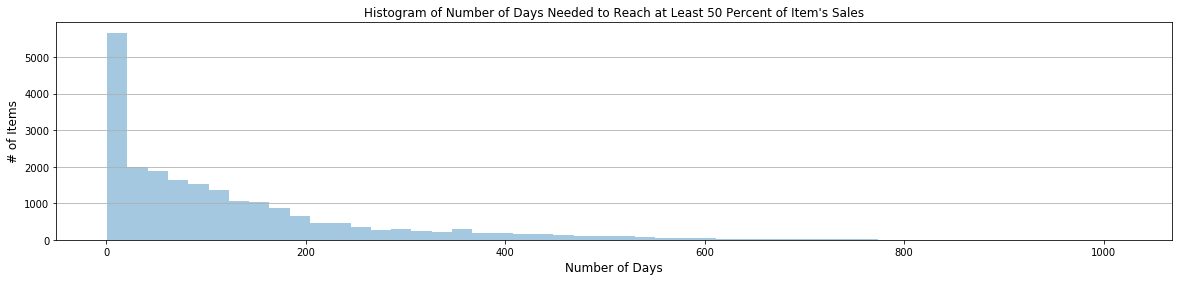

In [937]:
# plot histogram of number of days items needed to reach at least 50 percent of their total sales
fig, ax = plt.subplots(figsize=(20,4))
ax = sns.distplot(item_level_stats[item_level_stats.pct_sold_first_week >= 0.].days_to_50pct, kde=False)
plt.title("Histogram of Number of Days Needed to Reach at Least 50 Percent of Item's Sales")
plt.xlabel("Number of Days", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.grid(axis="y")
plt.show()

In [940]:
len(item_level_stats[item_level_stats.days_to_50pct <= 200]) / len(item_level_stats)

0.8047415967349933

**FINDING:** 80% of items reach at least 50% of their total sales within 200 days, but there are outliers with much longer times.

### TEST DATASET 

In [91]:
test_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/test.csv')

In [92]:
test_df.shape

(214200, 3)

In [93]:
test_df.head(10)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


In [114]:
test_df.duplicated().any()

False

**FINDING:** No duplicates in the test dataset

In [115]:
test_df.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

**FINDING:** No missing values in the test dataset

In [94]:
len(test_df.shop_id.unique())

42

In [97]:
len(test_df.item_id.unique())

5100

**FINDING:** The test dataset is created by including all possible combinations of the shop_id and item_ids in the dataset (i.e., 42 * 5,100 = 214,200). Why those 42 shops and 5,100 items are part of this test dataset is not clear though.

In [98]:
np.setdiff1d(test_df.shop_id.unique(), sales.shop_id.unique())

array([], dtype=int64)

**FINDING:** All shop_id values in the test dataset also exist in the train dataset.

In [99]:
np.setdiff1d(sales.shop_id.unique(), test_df.shop_id.unique())

array([ 0,  1,  8,  9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51,
       54])

**FINDING:** 18 shop_id values above exist in the train dataset but do not exist in the test dataset.

In [101]:
np.setdiff1d(test_df.item_id.unique(), sales.item_id.unique()).size

363

**FINDING:** 363 item_id values exist in the test dataset, but do not exist in the train dataset.

In [104]:
np.setdiff1d(sales.item_id.unique(), test_df.item_id.unique()).size

17070

**FINDING:** 17,070 item_id values exist in the train dataset, but do not exist in the test dataset.

In [133]:
np.intersect1d(sales.item_id.unique(), test_df.item_id.unique()).size

4737

**FINDING:** 4,737 item_id values exist in both the train and test datasets.

In [688]:
np.intersect1d(items_sold_one_day, test_df.item_id.unique()).size

86

In [689]:
np.setdiff1d(items_sold_one_day, test_df.item_id.unique()).size

2295

**FINDING:** 86 item_id values (out of the 2,381 that were sold on just one day each during the training period) also exist in the test dataset.

In [699]:
one_day_items_in_test_data = np.intersect1d(items_sold_one_day, test_df.item_id.unique())

In [701]:
item_level_stats[item_level_stats.item_id.isin(one_day_items_in_test_data)]['earliest_dt'] \
    .apply(lambda s: datetime.datetime(s.year, s.month, 1)).value_counts().sort_index()

2013-05-01     1
2013-11-01     1
2014-04-01     1
2014-08-01     1
2014-11-01     1
2014-12-01     5
2015-01-01     1
2015-02-01     4
2015-03-01     3
2015-04-01     5
2015-05-01     3
2015-06-01     1
2015-07-01     6
2015-08-01     1
2015-09-01     5
2015-10-01    47
Name: earliest_dt, dtype: int64

**FINDING:** 47 of the 86 items only sold on one day each during the training period were sold in October 2015, so it makes sense for them to also appear in the test data.

### ITEMS SUPPLEMENTAL INFORMATION DATASET 

In [105]:
items_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/items.csv')

In [106]:
items_df.shape

(22170, 3)

In [126]:
items_df.head(10)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [148]:
# Need to check if all item_ids (in train and test datasets) exist in the items_df dataset
np.setdiff1d(sales.item_id.unique(), items_df.item_id.unique()).size

0

In [149]:
np.setdiff1d(test_df.item_id.unique(), items_df.item_id.unique()).size

0

**FINDING:** All item_id values in the train and test datasets exist in the items_df dataset.

In [999]:
# Let's also check if there are any duplicates in the item_name column
items_df.item_name.duplicated().any()

False

**FINDING:** There are no duplicates in the item_name column.

In [423]:
#We can check on some of the item edge cases (weird quantities, prices, etc.)
items_df[items_df.item_id == 11373]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


**FINDING:** This item that had the largest value of quantity sold (2,169) is a delivery charge (by Boxberry service).

In [427]:
items_df[items_df.item_id == 8023]

,item_name,item_id,item_category_id
8023,ZL004 Лазерные наклейки Смайлики маленькие,8023,66


**FINDING:** This item that has the lowest (largest negative) quantity sold (-22) is laser stickers.

### ITEM CATEGORIES DATASET

In [108]:
categories_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/item_categories.csv')

In [109]:
categories_df.shape

(84, 2)

In [110]:
categories_df.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [112]:
categories_df.duplicated().any()

False

In [113]:
categories_df.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [116]:
categories_df.item_category_id.unique().size

84

In [127]:
categories_df.item_category_name.unique().size

84

**FINDING:** No duplicates or missing values in the categories_df dataset. Also, category names and category ids are all unique.

In [150]:
# Check if all categories of item_ids in train and test datasets also all exist in the categories_df dataset
np.setdiff1d(items_df.item_category_id.unique(), categories_df.item_category_id.unique()).size

0

**FINDING:** All categories of item_ids in the items_df dataset exist in the categories_df dataset.

In [165]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [170]:
# Check if there are categories of the 363 items that only appear in the test dataset that also only apply those 363 items.
items_only_in_test_df = np.setdiff1d(test_df.item_id.unique(), sales.item_id.unique())

cats_of_items_only_in_test_df = items_df[items_df.item_id.isin(items_only_in_test_df)]['item_category_id'].unique()

items_in_train_df = sales.item_id.unique()

cats_of_items_in_train_df = items_df[items_df.item_id.isin(items_in_train_df)]['item_category_id'].unique()

np.setdiff1d(cats_of_items_only_in_test_df, cats_of_items_in_train_df)

array([], dtype=int64)

**FINDING:** All categories of the 363 items that only appear in the test dataset also apply to items in the train dataset.

In [129]:
list(categories_df.item_category_name)

['PC - Гарнитуры/Наушники',
 'Аксессуары - PS2',
 'Аксессуары - PS3',
 'Аксессуары - PS4',
 'Аксессуары - PSP',
 'Аксессуары - PSVita',
 'Аксессуары - XBOX 360',
 'Аксессуары - XBOX ONE',
 'Билеты (Цифра)',
 'Доставка товара',
 'Игровые консоли - PS2',
 'Игровые консоли - PS3',
 'Игровые консоли - PS4',
 'Игровые консоли - PSP',
 'Игровые консоли - PSVita',
 'Игровые консоли - XBOX 360',
 'Игровые консоли - XBOX ONE',
 'Игровые консоли - Прочие',
 'Игры - PS2',
 'Игры - PS3',
 'Игры - PS4',
 'Игры - PSP',
 'Игры - PSVita',
 'Игры - XBOX 360',
 'Игры - XBOX ONE',
 'Игры - Аксессуары для игр',
 'Игры Android - Цифра',
 'Игры MAC - Цифра',
 'Игры PC - Дополнительные издания',
 'Игры PC - Коллекционные издания',
 'Игры PC - Стандартные издания',
 'Игры PC - Цифра',
 'Карты оплаты (Кино, Музыка, Игры)',
 'Карты оплаты - Live!',
 'Карты оплаты - Live! (Цифра)',
 'Карты оплаты - PSN',
 'Карты оплаты - Windows (Цифра)',
 'Кино - Blu-Ray',
 'Кино - Blu-Ray 3D',
 'Кино - Blu-Ray 4K',
 'Кино - DV

**FINDING:** It appears that there are groups of categories, like game consoles, movies, books, gifts, etc.  It will likely be very important to know when certain movies are released and what their popularity is, for example, as well as when new game consoles are introduced, etc.

In [154]:
# Testing filtering categories by the the first word in their name
mask = categories_df.item_category_name.str.startswith("Аксессуары")
categories_df.item_category_name[mask]

1         Аксессуары - PS2
2         Аксессуары - PS3
3         Аксессуары - PS4
4         Аксессуары - PSP
5      Аксессуары - PSVita
6    Аксессуары - XBOX 360
7    Аксессуары - XBOX ONE
Name: item_category_name, dtype: object

In [428]:
categories_df[categories_df.item_category_id == 66]

,item_category_name,item_category_id
66,"Подарки - Открытки, наклейки",66


In [942]:
# merge item_category_id and item_name (from items_df) and then item_category_name (from categories_df) onto sales_df data
sales_merged_w_items = sales.merge(items_df, how='left', on='item_id')

In [945]:
sales_w_item_and_cat_info = sales_merged_w_items.merge(categories_df, how='left', on='item_category_id')

In [947]:
sales_w_item_and_cat_info.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day_of_week,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,Wednesday,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,Thursday,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,Saturday,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,Sunday,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,Tuesday,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
5,2013-01-10,0,25,2564,349.00,1.0,Thursday,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео
6,2013-01-02,0,25,2565,549.00,1.0,Wednesday,DEEP PURPLE Stormbringer (фирм.),56,Музыка - CD фирменного производства
7,2013-01-04,0,25,2572,239.00,1.0,Friday,DEFTONES Koi No Yokan,55,Музыка - CD локального производства
8,2013-01-11,0,25,2572,299.00,1.0,Friday,DEFTONES Koi No Yokan,55,Музыка - CD локального производства
9,2013-01-03,0,25,2573,299.00,3.0,Thursday,DEL REY LANA Born To Die,55,Музыка - CD локального производства


In [949]:
sales_w_item_and_cat_info.item_category_name.value_counts(dropna=False).head(10)

Кино - DVD                                564651
Игры PC - Стандартные издания             351591
Музыка - CD локального производства       339585
Игры - PS3                                208219
Кино - Blu-Ray                            192673
Игры - XBOX 360                           146785
Игры PC - Дополнительные издания          121539
Игры - PS4                                 79058
Подарки - Мягкие игрушки                   53845
Подарки - Настольные игры (компактные)     53227
Name: item_category_name, dtype: int64

In [950]:
sales_w_item_and_cat_info.item_category_name.value_counts(dropna=False).tail(10)

Игры - PS2                           11
Игры MAC - Цифра                      8
Книги - Компьютерная литература       6
PC - Гарнитуры/Наушники               3
Книги - Художественная литература     3
Книги - Путеводители                  3
Аксессуары - PS2                      2
Книги - Открытки                      2
Игровые консоли - PS2                 1
Книги - Познавательная литература     1
Name: item_category_name, dtype: int64

**FINDING:** The most common categories of items sold are DVD movies, PC games, music CDs, and other types of games and movies.  The least common categories are PlayStation 2 items (probably because of age) and some types of books (fiction, computer literature, tour guides, etc.).

In [952]:
sales_w_item_and_cat_info.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'day_of_week', 'item_name', 'item_category_id',
       'item_category_name'],
      dtype='object')

In [953]:
sales_w_item_and_cat_info['revenue'] = sales_w_item_and_cat_info.item_price * sales_w_item_and_cat_info.item_cnt_day

In [956]:
sales_w_item_and_cat_info.groupby('item_category_name')['revenue'].sum().sort_values(ascending=False)[:10]

item_category_name
Игры - PS3                             4.120503e+08
Игры - PS4                             3.730103e+08
Игровые консоли - PS4                  2.922398e+08
Игры - XBOX 360                        2.596151e+08
Игры PC - Стандартные издания          2.575193e+08
Кино - DVD                             1.699441e+08
Игры PC - Дополнительные издания       1.364191e+08
Музыка - CD локального производства    1.000226e+08
Кино - Blu-Ray                         9.047823e+07
Программы - Для дома и офиса           8.708593e+07
Name: revenue, dtype: float64

**FINDING:** The items that brought in the most revenue are PS3 games (412 mln), PS4 games (373 mln), and PS4 game consoles (292 mln).

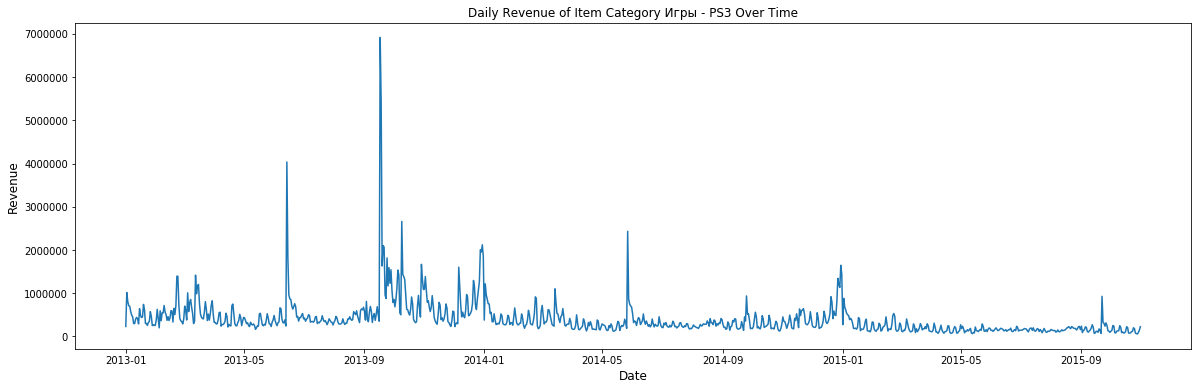

In [971]:
def plot_revenue_over_time(item_cat):
    total_rev_by_day = sales_w_item_and_cat_info.groupby(['date','item_category_name'])['revenue'].sum().reset_index()
    plt.figure(figsize=(20,6))
    ax = sns.lineplot(total_rev_by_day[total_rev_by_day.item_category_name == item_cat]['date'],
                      total_rev_by_day[total_rev_by_day.item_category_name == item_cat]['revenue'])
    plt.title(f"Daily Revenue of Item Category {item_cat} Over Time")
    plt.ylabel("Revenue", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.show()
    
plot_revenue_over_time('Игры - PS3')

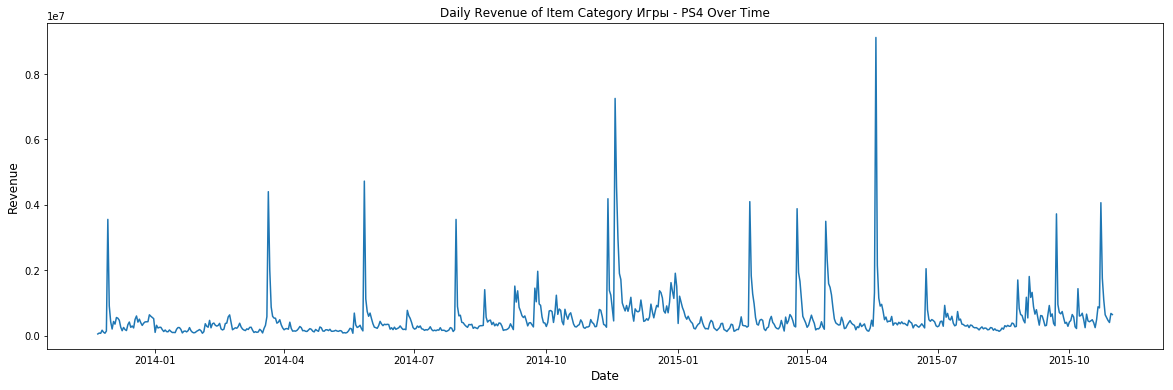

In [972]:
plot_revenue_over_time('Игры - PS4')

In [978]:
sales_w_item_and_cat_info['category_broad'] = sales_w_item_and_cat_info.item_category_name.apply(lambda x: x.split()[0])

In [979]:
sales_w_item_and_cat_info.category_broad.value_counts()

Игры          1029690
Кино           833414
Музыка         401862
Подарки        370450
Аксессуары      76238
Книги           69424
Программы       65234
Карты           37905
Игровые         24770
Служебные       10392
Элементы         7206
Чистые           5185
Доставка         2193
Билеты           1877
PC                  3
Name: category_broad, dtype: int64

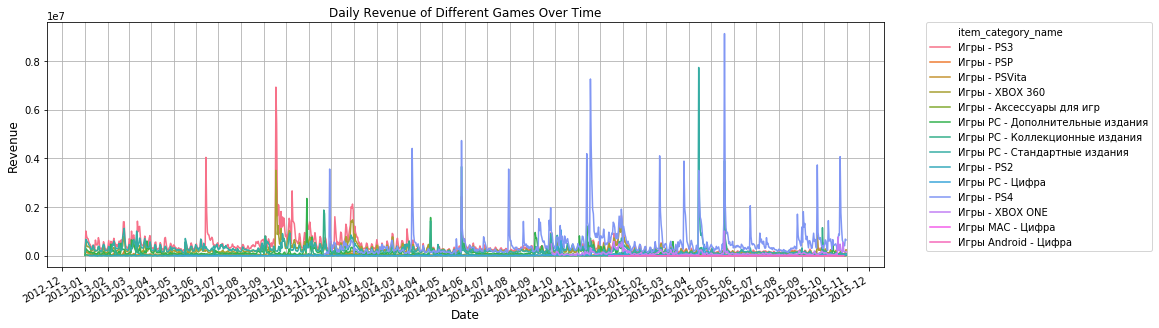

In [984]:
total_rev_by_day = sales_w_item_and_cat_info[sales_w_item_and_cat_info.category_broad == 'Игры'] \
    .groupby(['date','item_category_name'])['revenue'].sum().reset_index()

fig, ax1 = plt.subplots(figsize=(15,5))

ax1 = sns.lineplot(x=total_rev_by_day['date'], y=total_rev_by_day['revenue'], \
                   hue=total_rev_by_day['item_category_name'])

# Formatters for x-axis labels
months = mdates.MonthLocator()  # every month
date_fmt = mdates.DateFormatter('%Y-%m')
# We need to tell matplotlib that these are dates...
ax1.xaxis_date()
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(date_fmt)
fig.autofmt_xdate()

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Revenue", fontsize=12)
ax1.set_title("Daily Revenue of Different Games Over Time")
ax1.grid(True)
plt.show()

**FINDING:** As expected, it appears that demand for games for different consoles is temporary.  There are also short-term spikes throughout the period, probably representing dates of releases of popular games.

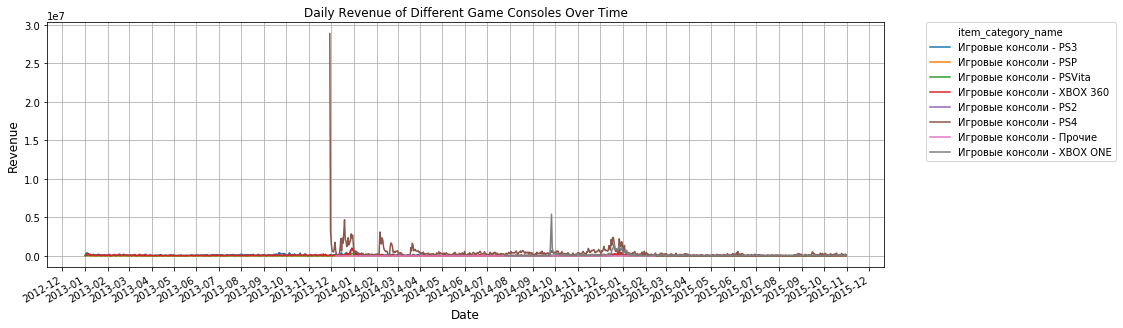

In [985]:
total_rev_by_day = sales_w_item_and_cat_info[sales_w_item_and_cat_info.category_broad == 'Игровые'] \
    .groupby(['date','item_category_name'])['revenue'].sum().reset_index()

fig, ax1 = plt.subplots(figsize=(15,5))

ax1 = sns.lineplot(x=total_rev_by_day['date'], y=total_rev_by_day['revenue'], \
                   hue=total_rev_by_day['item_category_name'])

# Formatters for x-axis labels
months = mdates.MonthLocator()  # every month
date_fmt = mdates.DateFormatter('%Y-%m')
# We need to tell matplotlib that these are dates...
ax1.xaxis_date()
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(date_fmt)
fig.autofmt_xdate()

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Revenue", fontsize=12)
ax1.set_title("Daily Revenue of Different Game Consoles Over Time")
ax1.grid(True)
plt.show()

**FINDING:** PlayStation 4 was released around the end of November 2013, which is consistent with the spike observed on this chart.

In [989]:
# Let's check what the categories of the 363 items that only exist in the test data are.
items_only_in_test_data = pd.DataFrame(np.setdiff1d(test_df.item_id.unique(), sales.item_id.unique()), columns=['item_id'])

In [994]:
items_only_in_test_data = items_only_in_test_data.merge(items_df, how='left', on='item_id')

In [996]:
items_only_in_test_data = items_only_in_test_data.merge(categories_df, how='left', on='item_category_id')
items_only_in_test_data.head()

,item_id,item_name,item_category_id,item_category_name
0,83,12/ДВЕНАДЦАТЬ (СР) (Регион),40,Кино - DVD
1,140,1С:Аудиокниги. Аладдин и другие восточные сказ...,45,Книги - Аудиокниги 1С
2,168,1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44,Книги - Аудиокниги (Цифра)
3,173,1С:Аудиокниги. Аудиоэнциклопедия для самых мал...,45,Книги - Аудиокниги 1С
4,204,"1С:Аудиокниги. Г.Р. Хаггард. Клеопатра [PC, Ци...",44,Книги - Аудиокниги (Цифра)


In [998]:
items_only_in_test_data.item_category_name.value_counts()

Кино - DVD                                71
Музыка - CD локального производства       38
Подарки - Фигурки                         28
Игры PC - Цифра                           25
Книги - Комиксы, манга                    22
Музыка - Винил                            21
Игры - PS4                                18
Игры - Аксессуары для игр                 12
Подарки - Настольные игры (компактные)    12
Подарки - Атрибутика                      11
Подарки - Настольные игры                 10
Книги - Аудиокниги 1С                      8
Музыка - CD фирменного производства        7
Игры - XBOX ONE                            7
Программы - Для дома и офиса (Цифра)       6
Игры PC - Дополнительные издания           5
Игры - XBOX 360                            5
Программы - Обучающие                      5
Программы - Обучающие (Цифра)              5
Книги - Методические материалы 1С          5
Игры PC - Стандартные издания              5
Книги - Аудиокниги (Цифра)                 4
Подарки - 

**FINDING:** There is a bunch of different categories of items among the 363 items that only exist in the test data, including DVDs, CDs, books, games, and others.

### SHOPS SUPPLEMENTAL INFORMATION DATASET

In [117]:
shops_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/shops.csv')

In [118]:
shops_df.shape

(60, 2)

In [119]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [121]:
shops_df.duplicated().any()

False

In [122]:
shops_df.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [123]:
shops_df.shop_id.unique().size

60

**FINDING:** There are no duplicates or missing values in the shops_df dataset.

In [124]:
shops_df.shop_name

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

**FINDING:** It appears that these shops are located in different parts of Russia and that it may be possible to identify specific locations, at least at city level. There may be online stores too.

### MACROECONOMIC DATA FROM SBERBANK COMPETITION 

In [195]:
macro_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/macro.csv')

In [196]:
macro_df.shape

(2484, 100)

In [197]:
macro_df.columns

Index(['timestamp', 'oil_urals', 'gdp_quart', 'gdp_quart_growth', 'cpi', 'ppi',
       'gdp_deflator', 'balance_trade', 'balance_trade_growth', 'usdrub',
       'eurrub', 'brent', 'net_capital_export', 'gdp_annual',
       'gdp_annual_growth', 'average_provision_of_build_contract',
       'average_provision_of_build_contract_moscow', 'rts', 'micex',
       'micex_rgbi_tr', 'micex_cbi_tr', 'deposits_value', 'deposits_growth',
       'deposits_rate', 'mortgage_value', 'mortgage_growth', 'mortgage_rate',
       'grp', 'grp_growth', 'income_per_cap',
       'real_dispos_income_per_cap_growth', 'salary', 'salary_growth',
       'fixed_basket', 'retail_trade_turnover',
       'retail_trade_turnover_per_cap', 'retail_trade_turnover_growth',
       'labor_force', 'unemployment', 'employment',
       'invest_fixed_capital_per_cap', 'invest_fixed_assets',
       'profitable_enterpr_share', 'unprofitable_enterpr_share',
       'share_own_revenues', 'overdue_wages_per_cap', 'fin_res_per_cap',
    

In [198]:
macro_df.timestamp.head()

0    2010-01-01
1    2010-01-02
2    2010-01-03
3    2010-01-04
4    2010-01-05
Name: timestamp, dtype: object

In [199]:
#convert timestamp values to datetime
macro_df['datetime'] = pd.to_datetime(macro_df.timestamp)

In [200]:
macro_df.datetime.describe()

count                    2484
unique                   2484
top       2015-10-18 00:00:00
freq                        1
first     2010-01-01 00:00:00
last      2016-10-19 00:00:00
Name: datetime, dtype: object

In [202]:
#check that there is datetime value for each day between the first and last day in the macro dataset
lastday = datetime.date(2016,10,19)
firstday = datetime.date(2010,1,1)
delta = lastday - firstday
print(delta.days + 1)

2484


**FINDING:** There is a row for every date between Jan 1, 2010 an Oct 19, 2016 in the macro_df dataset.

In [203]:
# Let's check which columns have missing values and how often.
miss_vls_macro = pd.DataFrame(macro_df.isnull().sum(axis=0).sort_values(ascending=False), columns=['Count'])
miss_vls_macro['Percent'] = miss_vls_macro['Count'].apply(lambda x: '{:.2f}%'.format((float(x) / macro_df.shape[0]) * 100))
miss_vls_macro[miss_vls_macro.Count > 0]

,Count,Percent
provision_retail_space_modern_sqm,1754,70.61%
provision_retail_space_sqm,1753,70.57%
old_education_build_share,1389,55.92%
modern_education_share,1389,55.92%
population_reg_sports_share,1023,41.18%
museum_visitis_per_100_cap,1023,41.18%
theaters_viewers_per_1000_cap,1023,41.18%
students_reg_sports_share,1023,41.18%
hospital_bed_occupancy_per_year,1023,41.18%
hospital_beds_available_per_cap,1023,41.18%


In [204]:
# Identify features without any missing values
miss_vls_macro[miss_vls_macro.Count == 0]

,Count,Percent
oil_urals,0,0.00%
datetime,0,0.00%
gdp_annual,0,0.00%
gdp_annual_growth,0,0.00%
average_provision_of_build_contract,0,0.00%
deposits_value,0,0.00%
mortgage_value,0,0.00%
mortgage_rate,0,0.00%
fixed_basket,0,0.00%
timestamp,0,0.00%


In [12]:
# Aggregate to monthly level the required metrics
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0